In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Project Scope: 

Predicting Closing Stock Prices with Technical Indicators

This project aims to develop a model to predict the closing stock prices of Amazon (AMZN), Google (GOOG), and Apple (AAPL) using technical indicators.

Objectives:

- Collect historical stock price data for AMZN, GOOG, and AAPL.

- Preprocess the data for machine learning.

- Identify and select relevant technical indicators for analysis.

- Train a machine learning model to predict closing stock prices based on the chosen indicators. Evaluate the model's performance on unseen data.

- Visualize the predicted prices and compare them to actual closing prices.

### Deliverables:

- A trained machine learning model capable of predicting closing stock prices for AMZN, GOOG, and AAPL.

- A report documenting the data collection, preprocessing, model selection, training process, and evaluation results.

### Scope Limitations:

- This project will focus on technical analysis and will not consider fundamental factors that may influence stock prices.

- The model's predictions will be for short-term horizons and should not be used for investment decisions.

- The accuracy of the predictions will be limited by the inherent volatility of the stock market and the chosen technical indicators.

### Technical Considerations:

- Data acquisition methods using yahoo finance API
- Selection of technical indicators (e.g., Moving Average Convergence Divergence (MACD), Boolinger Bands, Exponential Moving Average, Momentum, Moving Average)
- Choice of machine learning model (LSTM)
- Model evaluation metrics (R squared)

### Tools and Technologies:

- Programming languages (Python)
- Machine learning libraries (Scikit-learn, TensorFlow)
- Data analysis libraries (pandas)
- Data visualization libraries (Matplotlib, Seaborn)

### Further Considerations:

- The project can be extended to explore more complex models (e.g., deep learning) or incorporate additional data sources (e.g., news sentiment).

- Backtesting the model's performance on historical data can provide insights into its potential profitability.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293147 sha256=3250b8b8567ce487efba8bf5f78746b4bc2bc8bfe5f42f10672444487d53bf18
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [5]:
import yfinance as yf

In [6]:
apple_data = yf.download('AAPL', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()
google_data = yf.download('GOOG', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()
microsoft_data = yf.download('MSFT', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Apple Stock Analysis

In [7]:
apple_data.head()

Date       Open       High        Low      Close  Adj Close     Volume
0 2015-01-02  27.847500  27.860001  26.837500  27.332500  24.435261  212818400
1 2015-01-05  27.072500  27.162500  26.352501  26.562500  23.746887  257142000
2 2015-01-06  26.635000  26.857500  26.157499  26.565001  23.749123  263188400
3 2015-01-07  26.799999  27.049999  26.674999  26.937500  24.082138  160423600
4 2015-01-08  27.307501  28.037500  27.174999  27.972500  25.007433  237458000

In [8]:
apple_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
apple_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
apple_data['stock_type'] = 'AAPL'

In [11]:
# verifying the data if the stock splits have been adjusted
# Apple stock split happend to 1:4 ration on Aug 31 2020
apple_data[(apple_data['Date'] < '2020-09-05') & (apple_data['Date'] > '2020-08-26')]

Date        Open        High         Low       Close   Adj Close  \
1423 2020-08-27  127.142502  127.485001  123.832497  125.010002  122.472679   
1424 2020-08-28  126.012497  126.442497  124.577499  124.807503  122.274284   
1425 2020-08-31  127.580002  131.000000  126.000000  129.039993  126.420883   
1426 2020-09-01  132.759995  134.800003  130.529999  134.179993  131.456528   
1427 2020-09-02  137.589996  137.979996  127.000000  131.399994  128.732971   
1428 2020-09-03  126.910004  128.839996  120.500000  120.879997  118.426506   
1429 2020-09-04  120.070000  123.699997  110.889999  120.959999  118.504890   

         Volume stock_type  
1423  155552400       AAPL  
1424  187630000       AAPL  
1425  225702700       AAPL  
1426  151948100       AAPL  
1427  200119000       AAPL  
1428  257599600       AAPL  
1429  332607200       AAPL

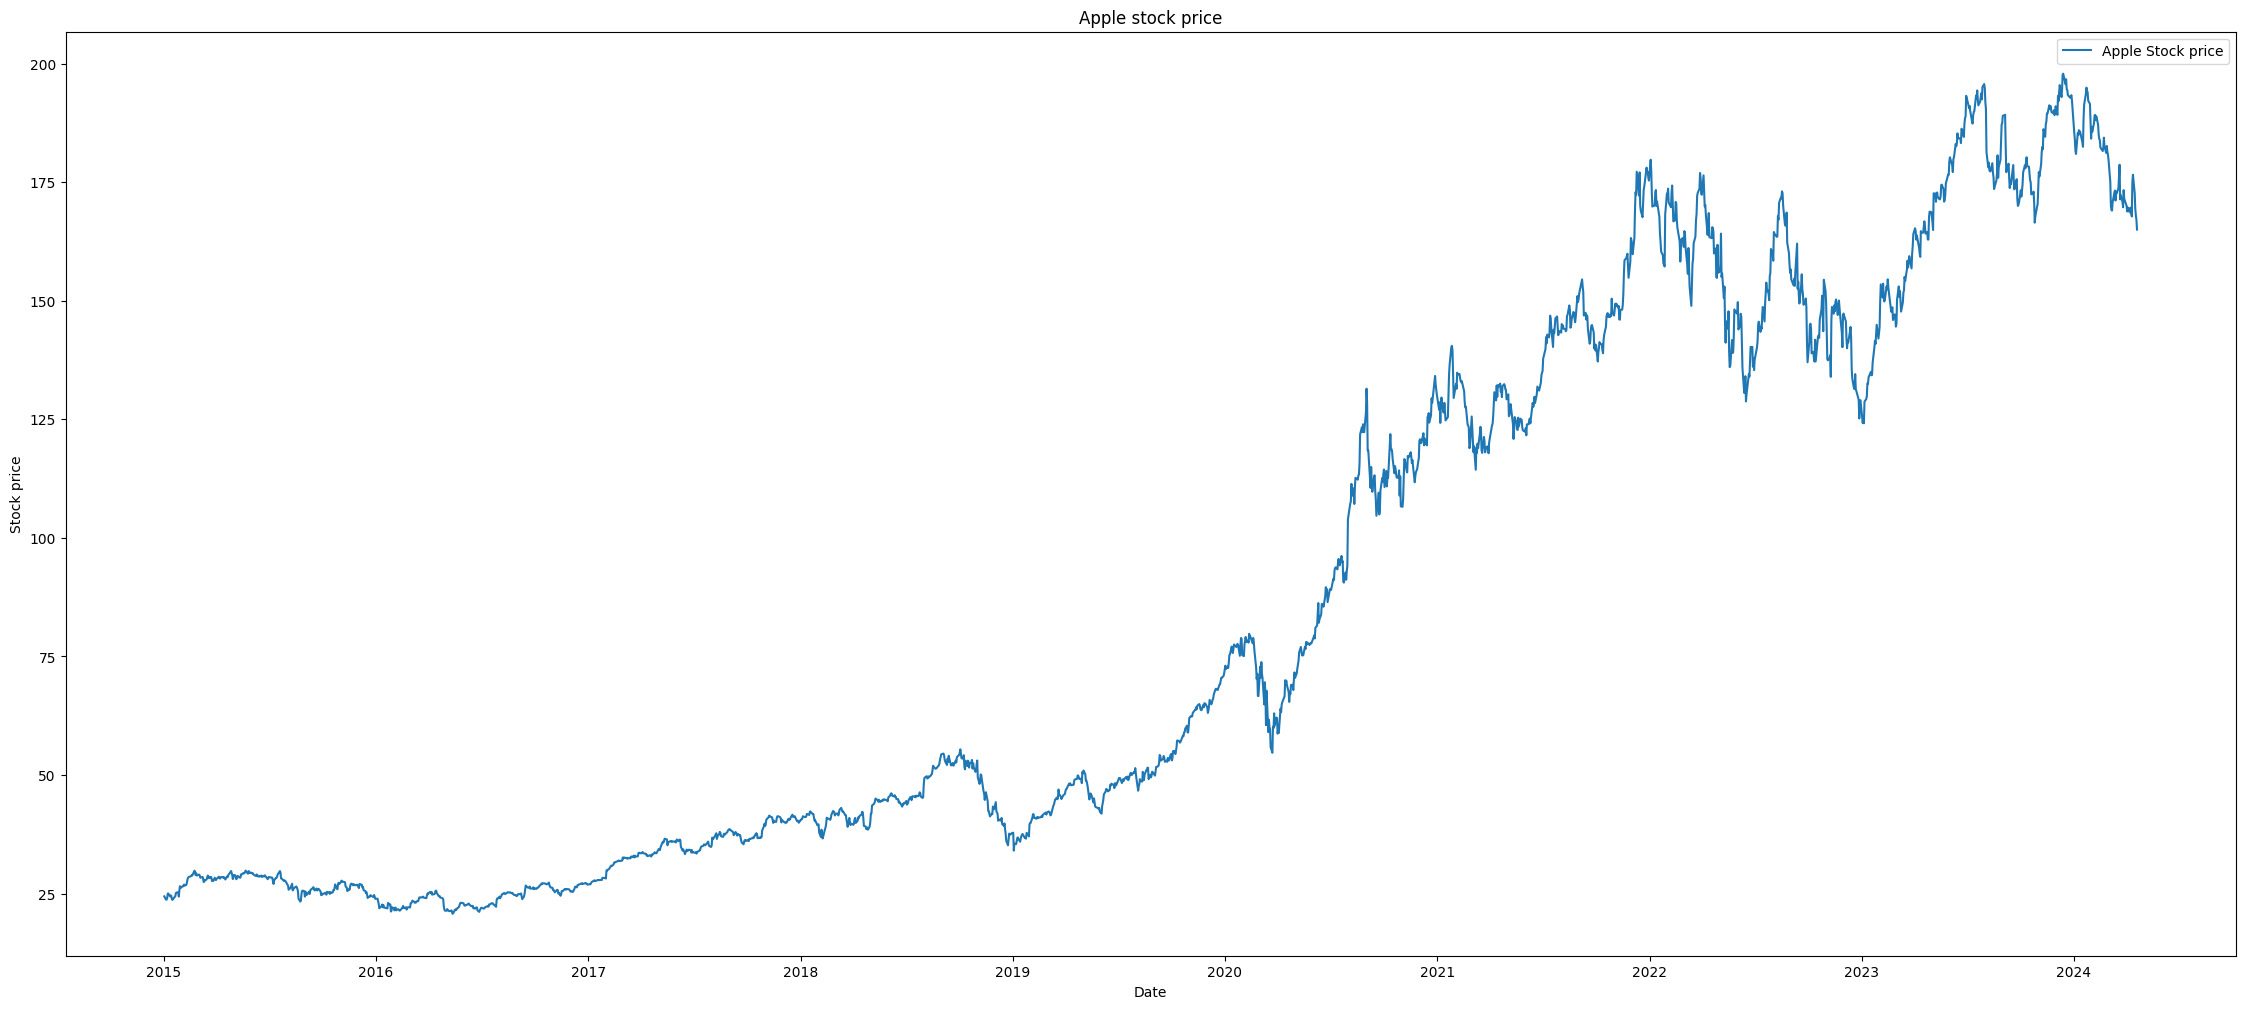

In [12]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(apple_data['Date'],apple_data['Adj Close'], label='Apple Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Apple stock price')
plt.legend()
plt.show()

### Moving Average

Moving Average (MA) is a tool used to smooth out stock price fluctuations and see the general trend. 

Similarly, a moving average in your project tracks the average closing price of a stock over a chosen period, let's say 7 days. Each day, the average is recalculated, dropping the oldest data point and adding the latest closing price. This creates a smoother line on the stock price chart that reflects the general upward, downward, or flat movement.

##### Here's how it helps predict prices (with a big caution):

- Upward trend: If the moving average line is sloping upwards, it suggests the stock price has generally been increasing over that period. This might indicate a potential for continued growth, but not a guarantee.

- Downward trend: Conversely, a downward-sloping moving average suggests a general decline in price, which could signal a downtrend.

- Flat trend: A flat moving average might indicate the stock price is fluctuating without a clear direction.

##### Important points to remember:

- Moving averages are lagging indicators, meaning they react to past price movements. They don't predict the future for sure.

- Different moving average lengths (e.g., 20 days vs. 200 days) can give slightly different trend signals.

- There can be false signals – prices might break out of the trend suggested by the moving average.

### MACD

Moving Average Convergence Divergence (MACD) is a popular technical indicator used in your project to gauge momentum and potential turning points in stock prices. Imagine you're on a seesaw. The MACD helps you understand if the seesaw is going up and down quickly (strong momentum) or if the movements are getting smaller (momentum weakening).

##### How it works:

- Two Moving Averages: MACD uses two moving averages of the closing price, a shorter one (say, 12 days) and a longer one (say, 26 days).

- The MACD Line: This is the difference between the shorter and longer moving averages. It shows how much the shorter average is above or below the longer one.

- The Signal Line: This is a moving average of the MACD line itself (often 9 days). It smooths out the MACD line to make it easier to identify trends.

##### Interpreting the MACD:

- Crossovers:  When the MACD line crosses above the signal line, it might suggest a potential upward trend in price (bullish signal). Conversely, if the MACD line crosses below the signal line, it could indicate a potential downward trend (bearish signal).

- Divergence: Sometimes, the stock price might be moving in one direction, while the MACD line moves in the opposite direction. This "divergence" can warn of a possible trend reversal.

##### Things to Note:

- MACD is a momentum indicator, not a crystal ball. It helps identify potential turning points, but future price movements can be unpredictable.

- There can be false signals, where the MACD suggests a trend change that doesn't happen.

- MACD is often used with other technical indicators for a more well-rounded analysis.

### Bollinger Bands

They help visualize price volatility (how much the price fluctuates) and identify potential overbought or oversold situations.

##### How it works:

- Middle Band: This is a moving average of the closing price, often over 20 days. It represents the "normal" price zone.

- Upper and Lower Bands: These are set a certain distance (usually two standard deviations) above and below the middle band. The distance is like the stretchiness of the toy.

##### Interpreting Bollinger Bands:

- Narrow Bands: When the bands are close together, it suggests low volatility. The stock price might be stuck in a trading range, and a breakout (price moving decisively above or below the bands) could signal a potential trend change.

- Wide Bands: Wider bands indicate higher volatility. The price might be swinging more, and it's harder to predict the next move.

- Price touching the Bands: If the price touches the upper band, it might be considered "overbought," and a pullback (price decline) could be due. Conversely, a price at the lower band could be seen as "oversold," and a bounce back might be possible.

##### Things to Note:

- Bollinger Bands don't guarantee future price movements. They just show the relative volatility and overbought/oversold zones based on recent price history.

- False signals can happen where the price bounces off the bands but doesn't reverse the trend.

- Bollinger Bands work best when used with other technical indicators in your project for a more comprehensive view.

### Exponential Moving Average

##### How EMA works:

 - Weights recent prices more: Unlike a regular average, EMA assigns a higher weight to the latest closing price and gradually less weight to prices further back. It's like a weighted average that favors the freshest data.
 
- Reacts faster to changes: Because it emphasizes recent prices, EMA reacts quicker to price movements compared to a regular moving average. It helps you see trends forming earlier.

##### Benefits for prediction:

- Adapts to trends: EMA is more flexible and can adjust to changing trends in the stock price because it focuses on recent data.

- Reduces lag: Compared to a regular moving average, EMA reacts faster to price movements, potentially giving you a slight edge in predicting short-term trends.

##### Things to Note:

- EMA is a lagging indicator: It still reacts to past prices, not predicting the future perfectly.

- Choosing the right period: The weight assigned to recent prices depends on the chosen EMA period. A shorter period emphasizes very recent data for quicker trend detection, while a longer period smooths things out a bit.

- Use with other tools: EMA is just one piece of the puzzle. Combine it with other technical indicators and fundamental analysis for a more informed prediction in your project.

### Momentum

Momentum refers to the speed and direction of a stock's price movement.

##### How momentum is measured:

compare the current closing price to the closing price from a set period ago (e.g., 10 days). If the current price is higher, there's positive momentum, suggesting the price might keep going up (but not guaranteed). If it's lower, there's negative momentum, hinting at a possible decline.

##### How momentum helps with prediction:

- Identify trends: By looking at momentum, you can get a feel for whether a stock's price is in an uptrend, downtrend, or staying flat. This can be helpful for predicting short-term movements, especially when combined with other indicators.

- Spot potential breakouts: If momentum is strong in one direction (up or down), it might suggest the price is nearing a breakout from its current trading range.

##### Things to Consider:

- Momentum is a lagging indicator, based on past price changes. It doesn't predict the future.

- Trends can reverse, and strong momentum can fade. Just because a stock is going up quickly doesn't mean it will keep doing so.

- Momentum is a useful tool, but for a more robust prediction strategy in your project, consider it alongside other technical indicators and fundamental analysis.

In [13]:
def get_technical_indicators(dataset, col_name):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[col_name].rolling(window=7).mean()
    dataset['ma21'] = dataset[col_name].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset[col_name].ewm(span=26).mean()
    dataset['12ema'] = dataset[col_name].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset[col_name].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[col_name].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[col_name]-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [14]:
apple_df = get_technical_indicators(apple_data, 'Adj Close')

In [15]:
def plot_technical_indicators(dataset, col_name, last_days, stock_name):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[col_name],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for {} - last {} days.'.format(stock_name, last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

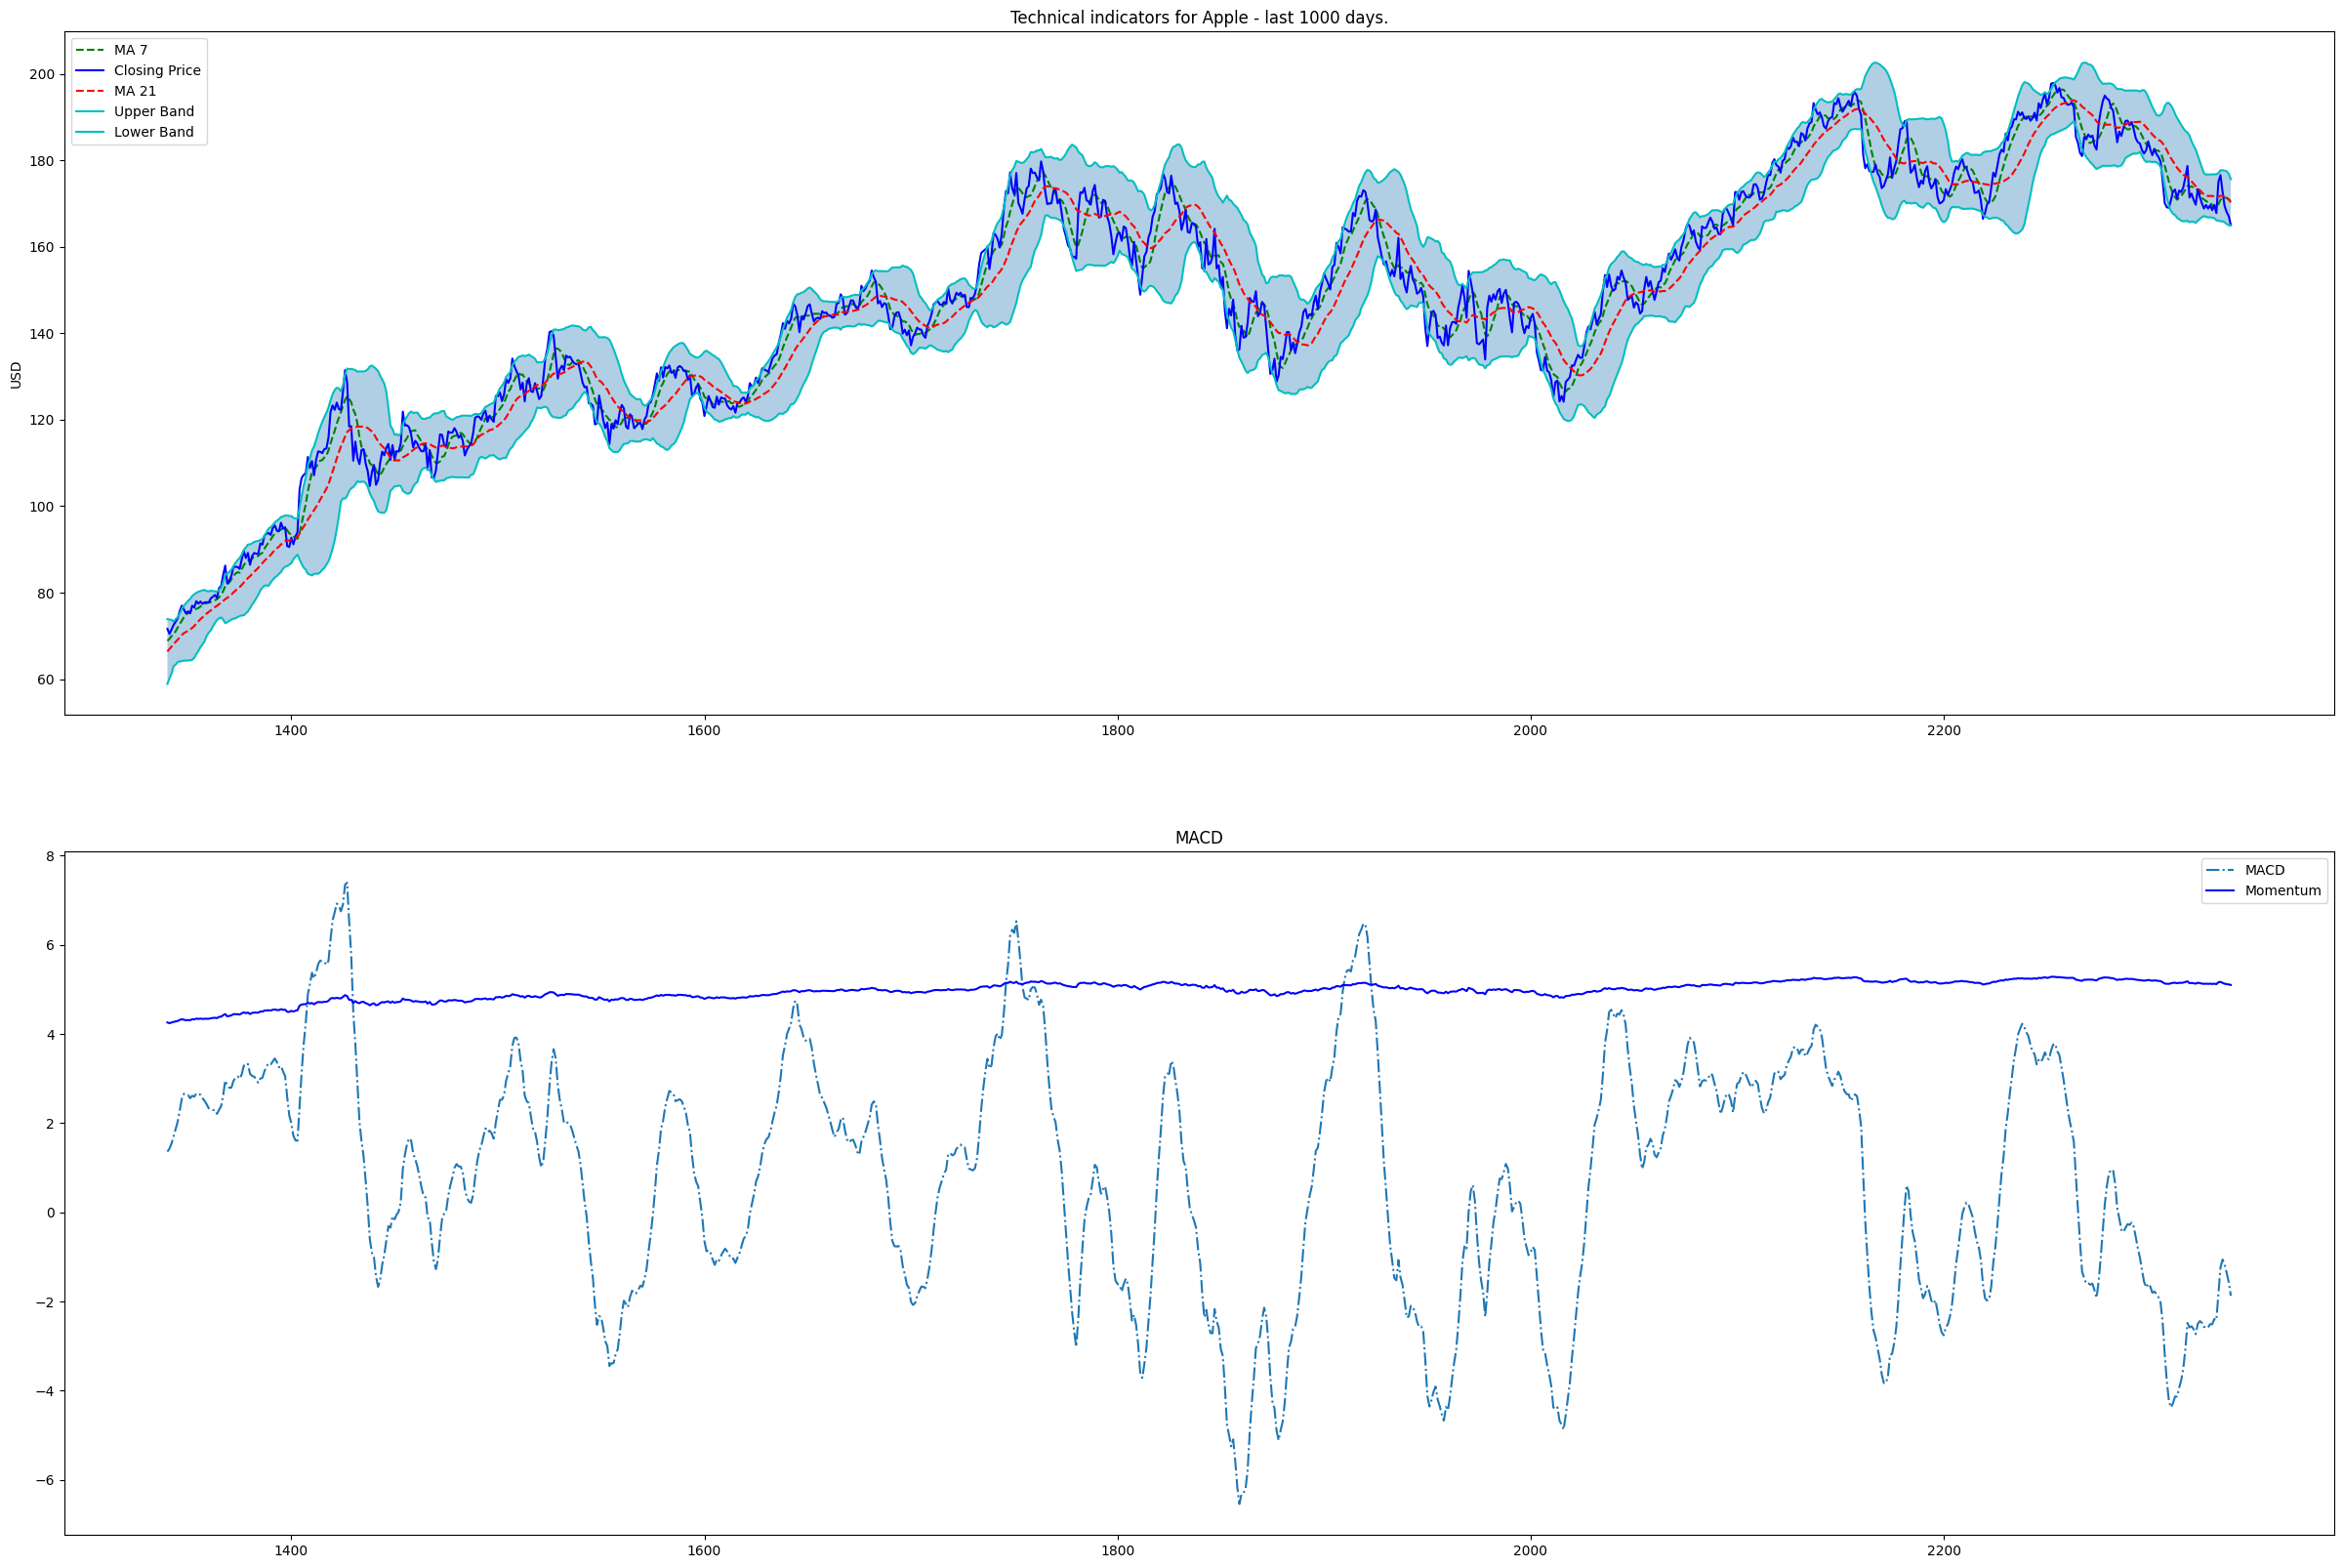

In [16]:
plot_technical_indicators(apple_df, 'Adj Close', 1000, 'Apple')

Text(0.5, 1.0, 'Params')

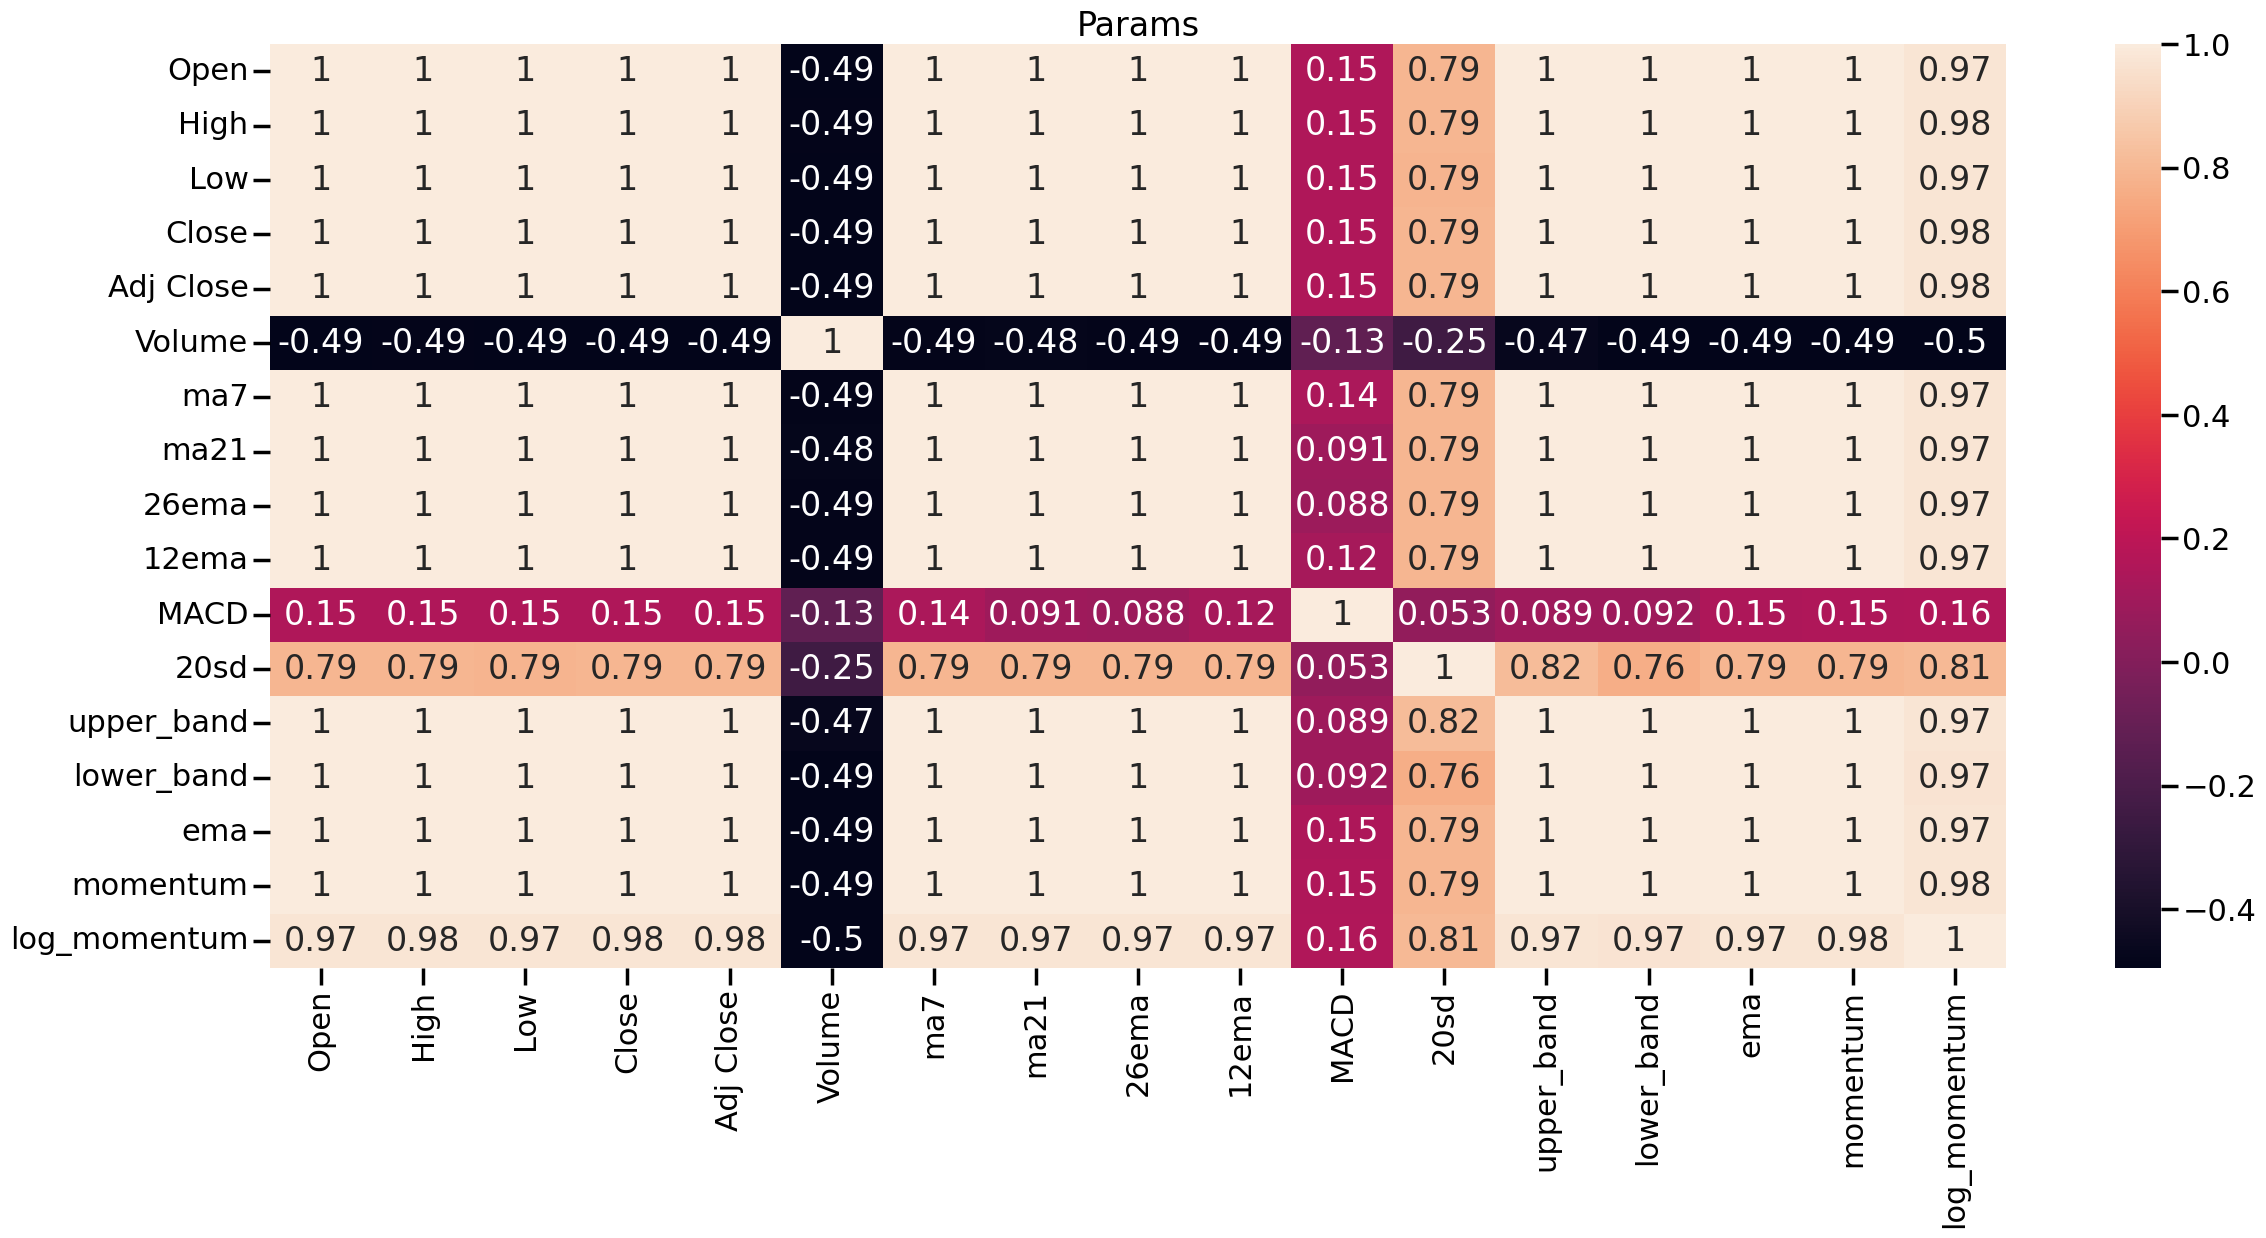

In [17]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(apple_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Google Stock Analysis

In [18]:
google_data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2015-01-02  26.378078  26.490770  26.133251  26.168653  26.168653  28951268
1 2015-01-05  26.091366  26.144720  25.582764  25.623152  25.623152  41196796
2 2015-01-06  25.679497  25.738087  24.983908  25.029282  25.029282  57998800
3 2015-01-07  25.280592  25.292759  24.914099  24.986401  24.986401  41301082
4 2015-01-08  24.831326  25.105074  24.482782  25.065184  25.065184  67071641

In [19]:
google_data.tail()

Date        Open        High         Low       Close   Adj Close  \
2335 2024-04-15  160.279999  160.830002  156.149994  156.330002  156.330002   
2336 2024-04-16  155.639999  157.229996  155.050003  156.000000  156.000000   
2337 2024-04-17  157.190002  158.681000  156.134995  156.880005  156.880005   
2338 2024-04-18  156.925003  158.485001  156.210007  157.460007  157.460007   
2339 2024-04-19  157.750000  157.990005  153.910004  155.720001  155.720001   

        Volume  
2335  21140900  
2336  15413200  
2337  16237800  
2338  14016100  
2339  20063900

In [20]:
google_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [21]:
google_data['stock_type'] = 'GOOG'

In [22]:
# verifying the data if the stock splits have been adjusted
# Google stock split happend to 1:20 ratio on July 18 2022
google_data[(google_data['Date'] < '2022-07-25') & (google_data['Date'] > '2022-07-13')]

Date        Open        High         Low       Close   Adj Close  \
1895 2022-07-14  110.825996  111.987503  109.325500  111.440002  111.440002   
1896 2022-07-15  112.962997  114.000504  111.822502  112.766998  112.766998   
1897 2022-07-18  113.440002  114.800003  109.300003  109.910004  109.910004   
1898 2022-07-19  111.730003  114.809998  110.500000  114.620003  114.620003   
1899 2022-07-20  114.059998  116.330002  113.260002  114.699997  114.699997   
1900 2022-07-21  115.089996  115.209999  111.910004  115.040001  115.040001   
1901 2022-07-22  111.809998  113.180000  107.599998  108.360001  108.360001   

        Volume stock_type  
1895  32366000       GOOG  
1896  34330000       GOOG  
1897  33354000       GOOG  
1898  30992300       GOOG  
1899  26780100       GOOG  
1900  27267800       GOOG  
1901  44455300       GOOG

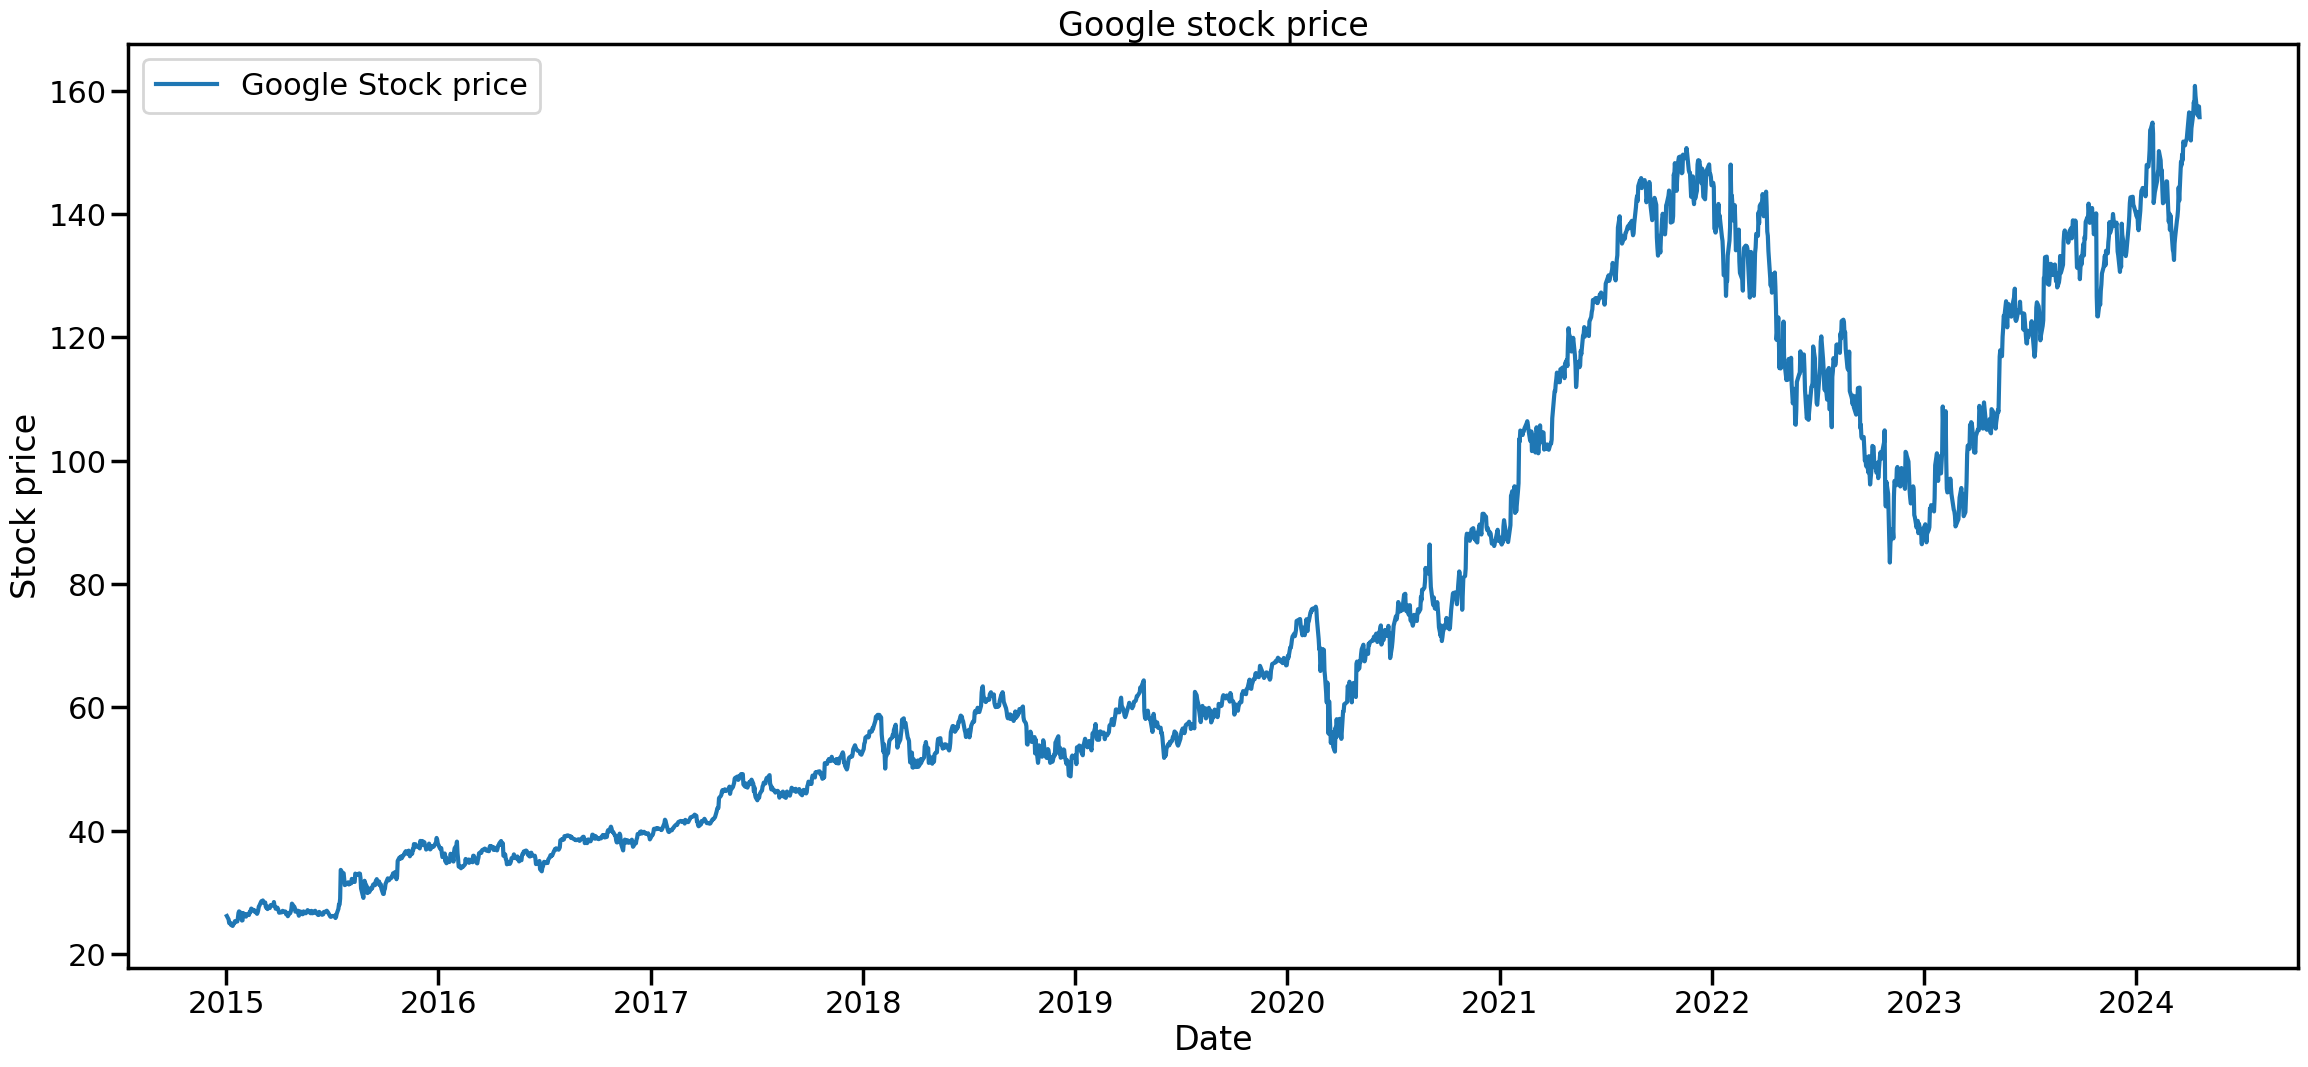

In [23]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(google_data['Date'],google_data['Adj Close'], label='Google Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Google stock price')
plt.legend()
plt.show()

In [24]:
google_df = get_technical_indicators(google_data, 'Adj Close')

<Figure size 1600x1000 with 0 Axes>

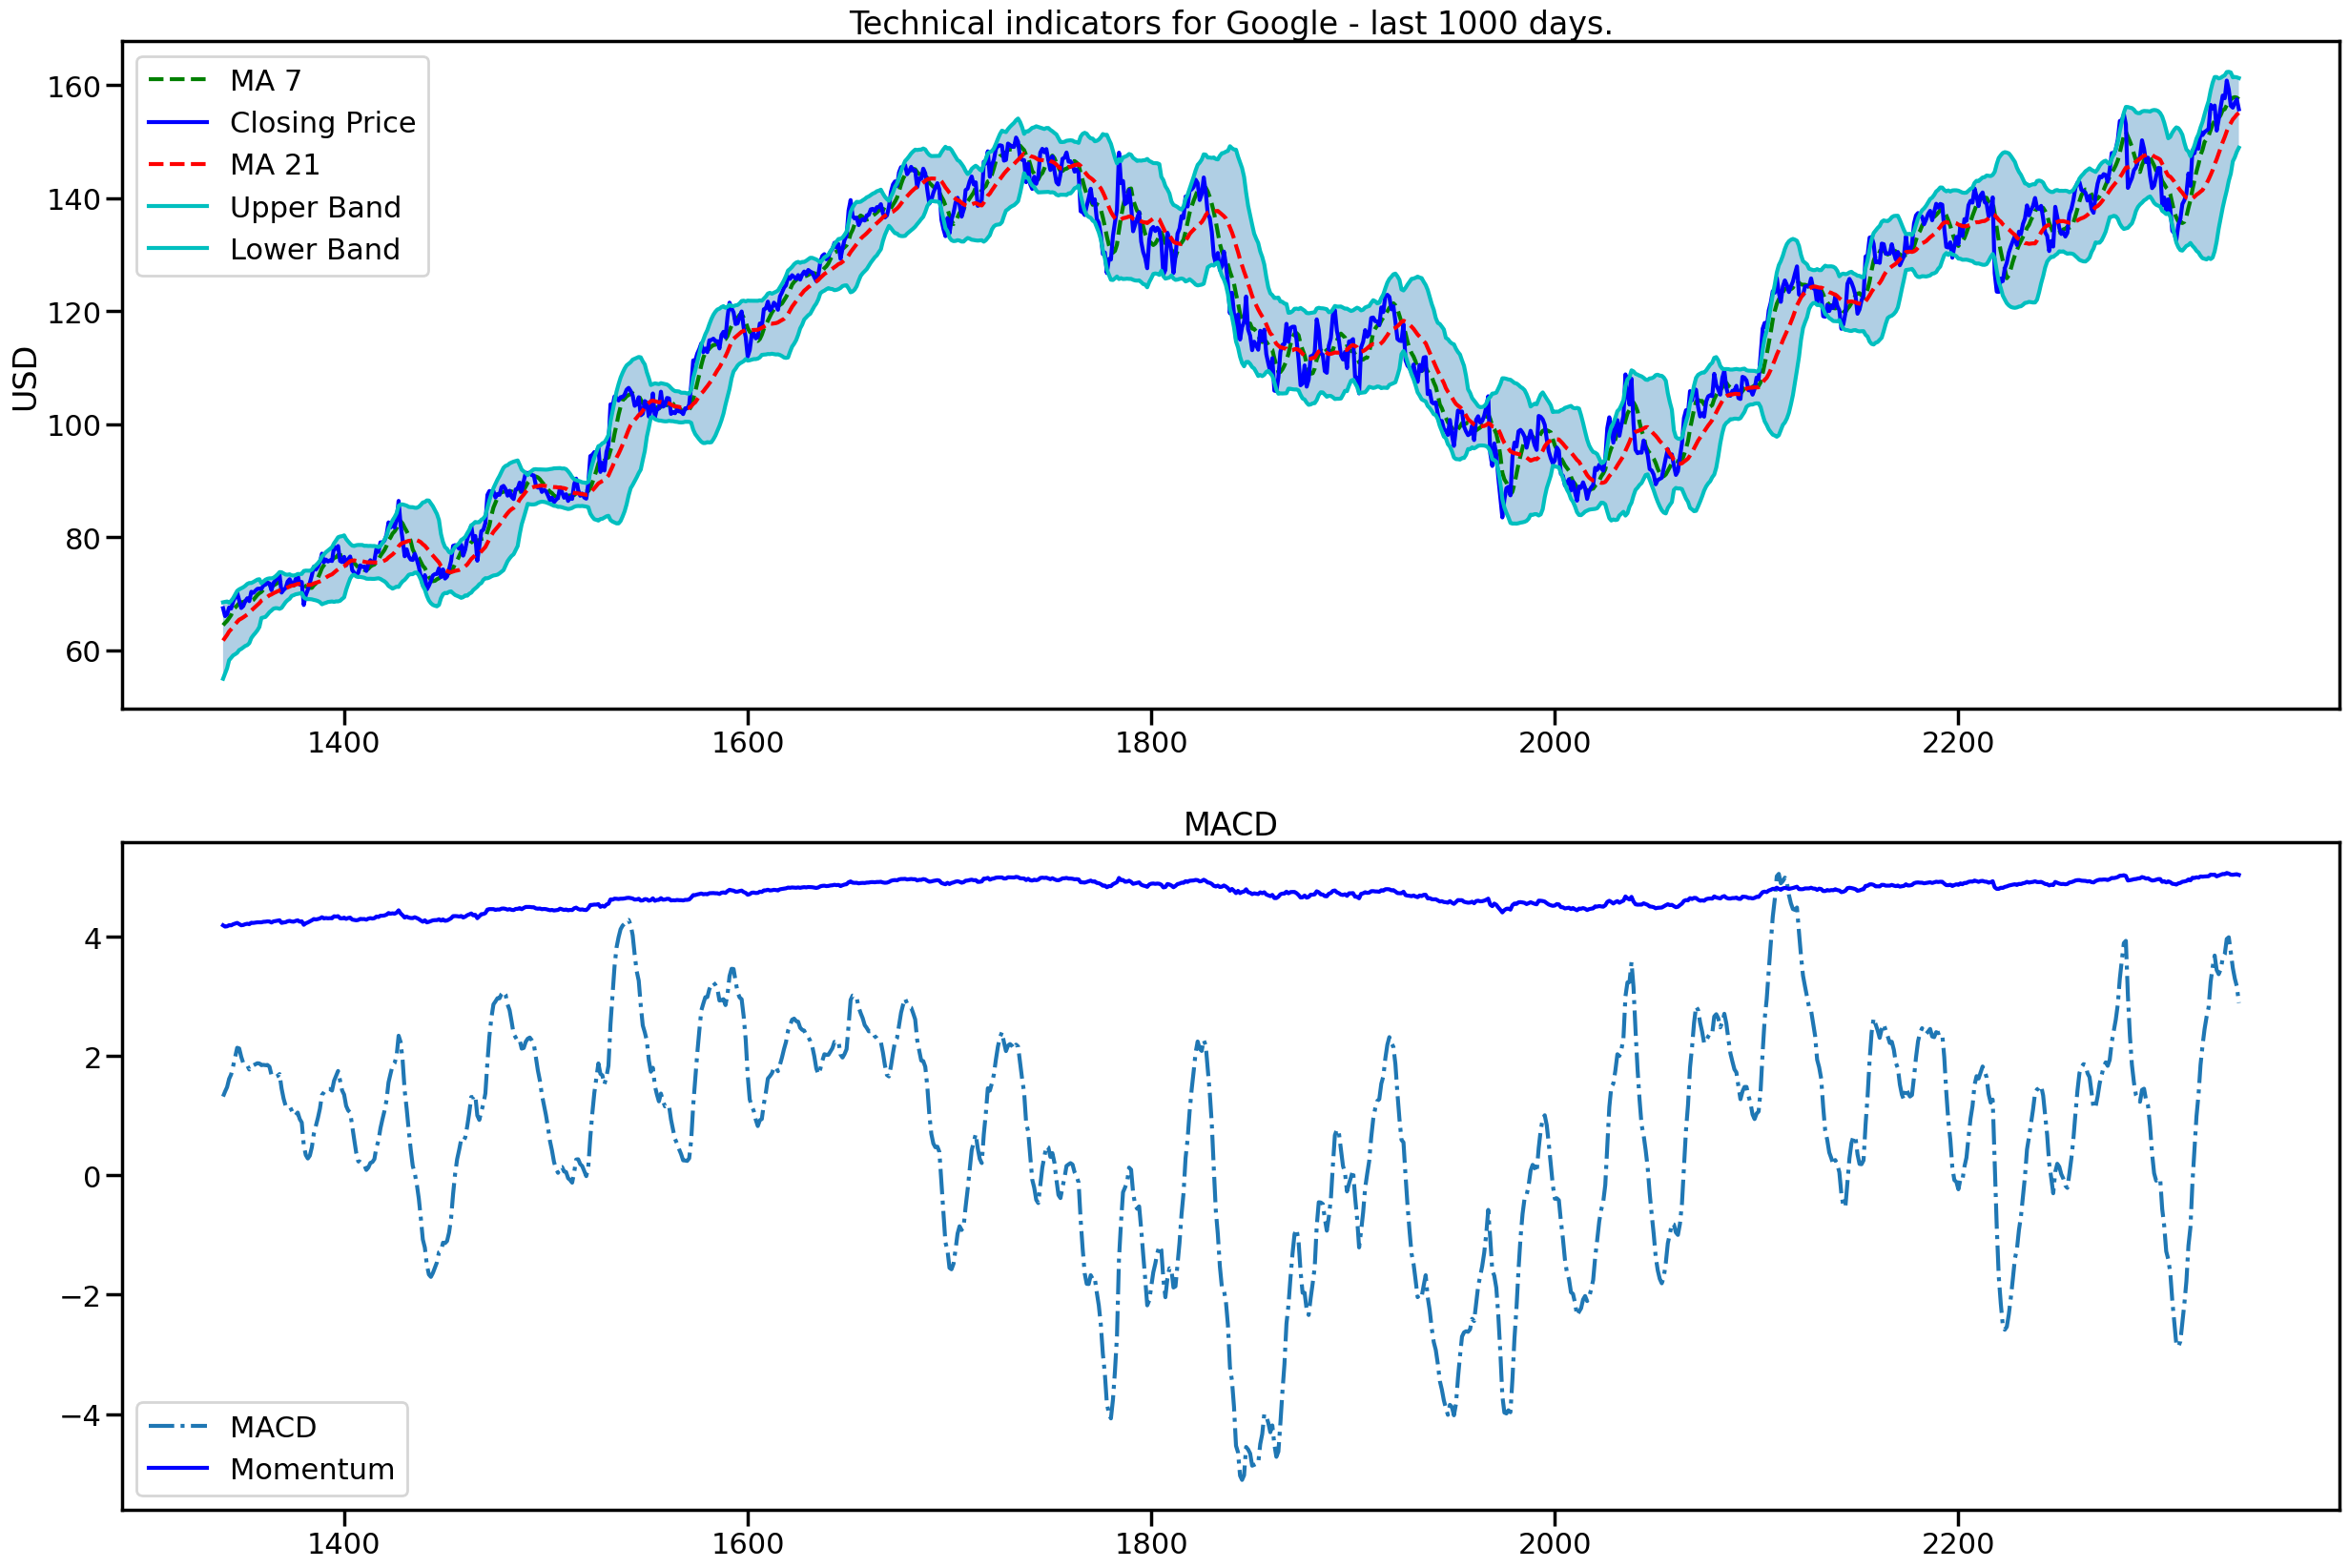

In [25]:
plot_technical_indicators(google_df, 'Adj Close', 1000, 'Google')

Text(0.5, 1.0, 'Params')

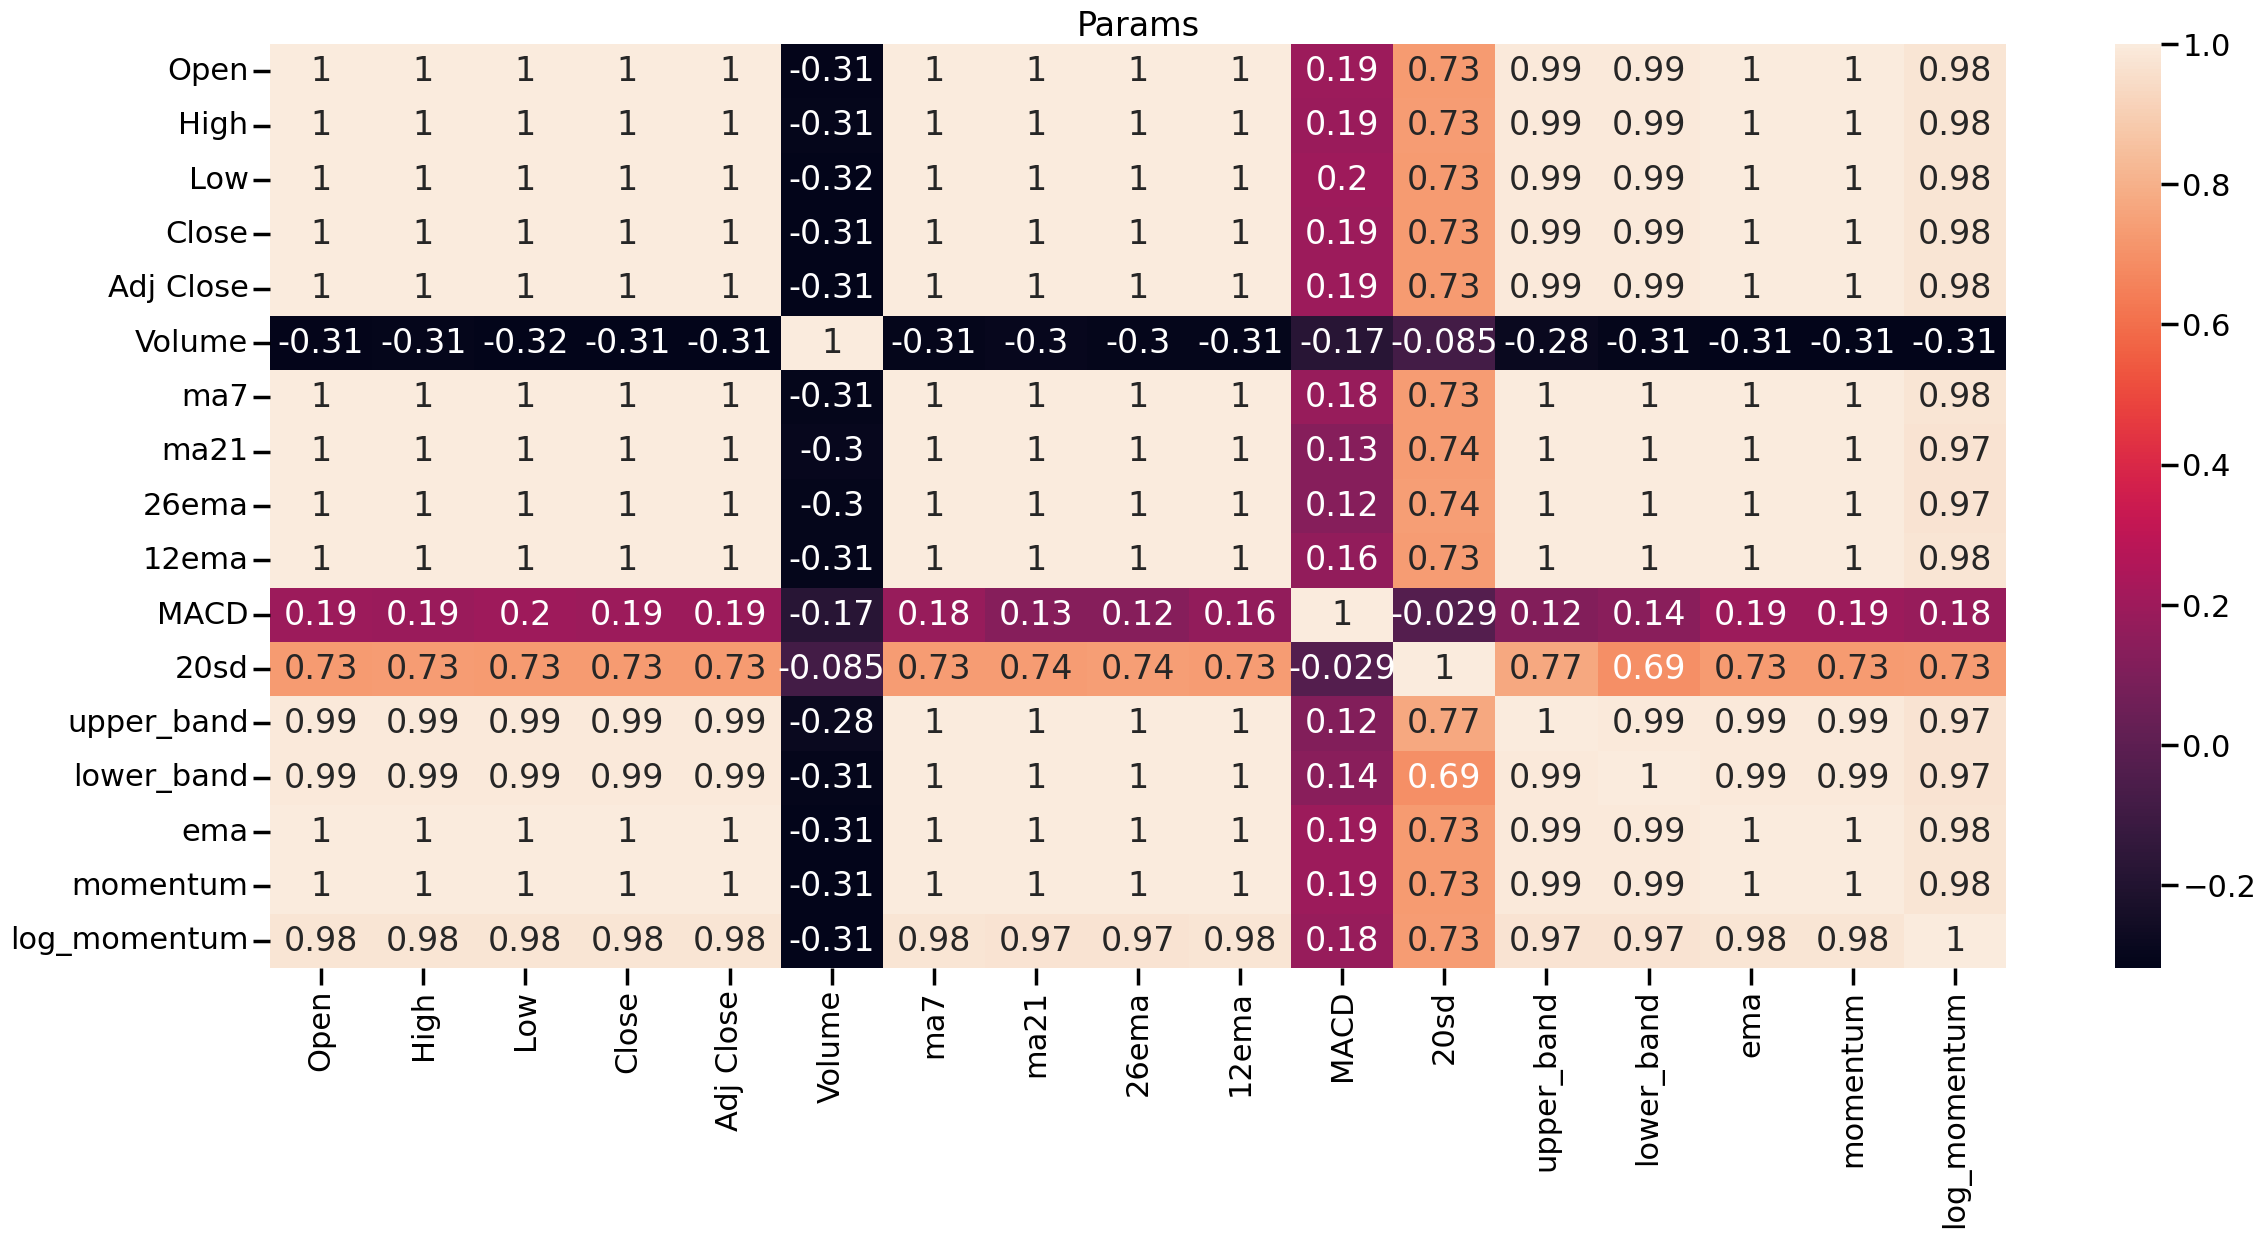

In [26]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(google_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Microsoft Stocks Analysis

In [27]:
microsoft_data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2015-01-02  46.660000  47.419998  46.540001  46.759998  40.378063  27913900
1 2015-01-05  46.369999  46.730000  46.250000  46.330002  40.006760  39673900
2 2015-01-06  46.380001  46.750000  45.540001  45.650002  39.419571  36447900
3 2015-01-07  45.980000  46.459999  45.490002  46.230000  39.920395  29114100
4 2015-01-08  46.750000  47.750000  46.720001  47.590000  41.094791  29645200

##### No stock splits happend in Microsoft during the period 2015 - 2023

In [28]:
microsoft_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
microsoft_data['stock_type'] = 'MSFT'

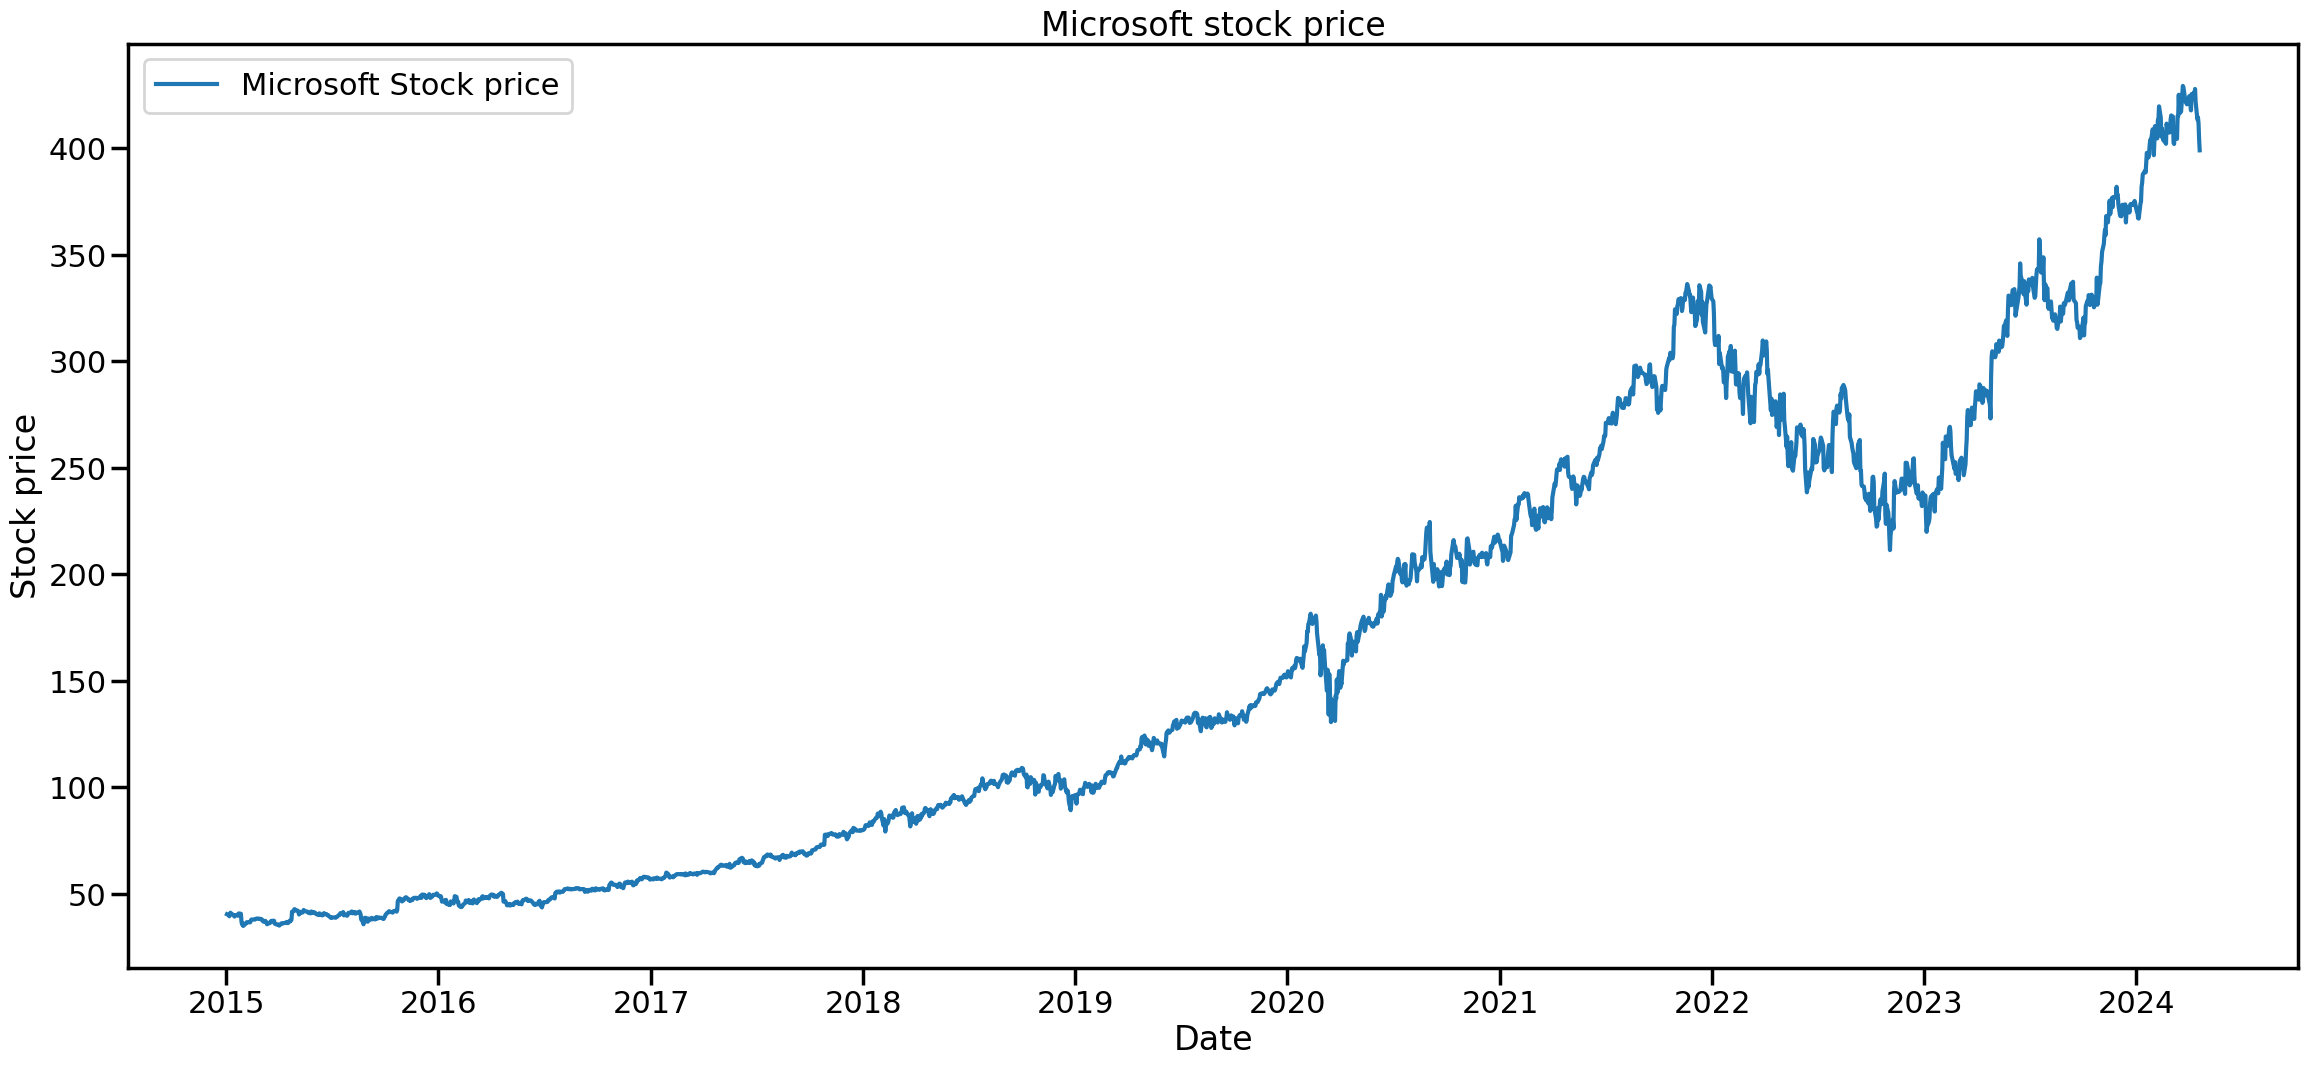

In [30]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(microsoft_data['Date'],microsoft_data['Adj Close'], label='Microsoft Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Microsoft stock price')
plt.legend()
plt.show()

In [31]:
microsoft_df = get_technical_indicators(microsoft_data, 'Adj Close')

<Figure size 1600x1000 with 0 Axes>

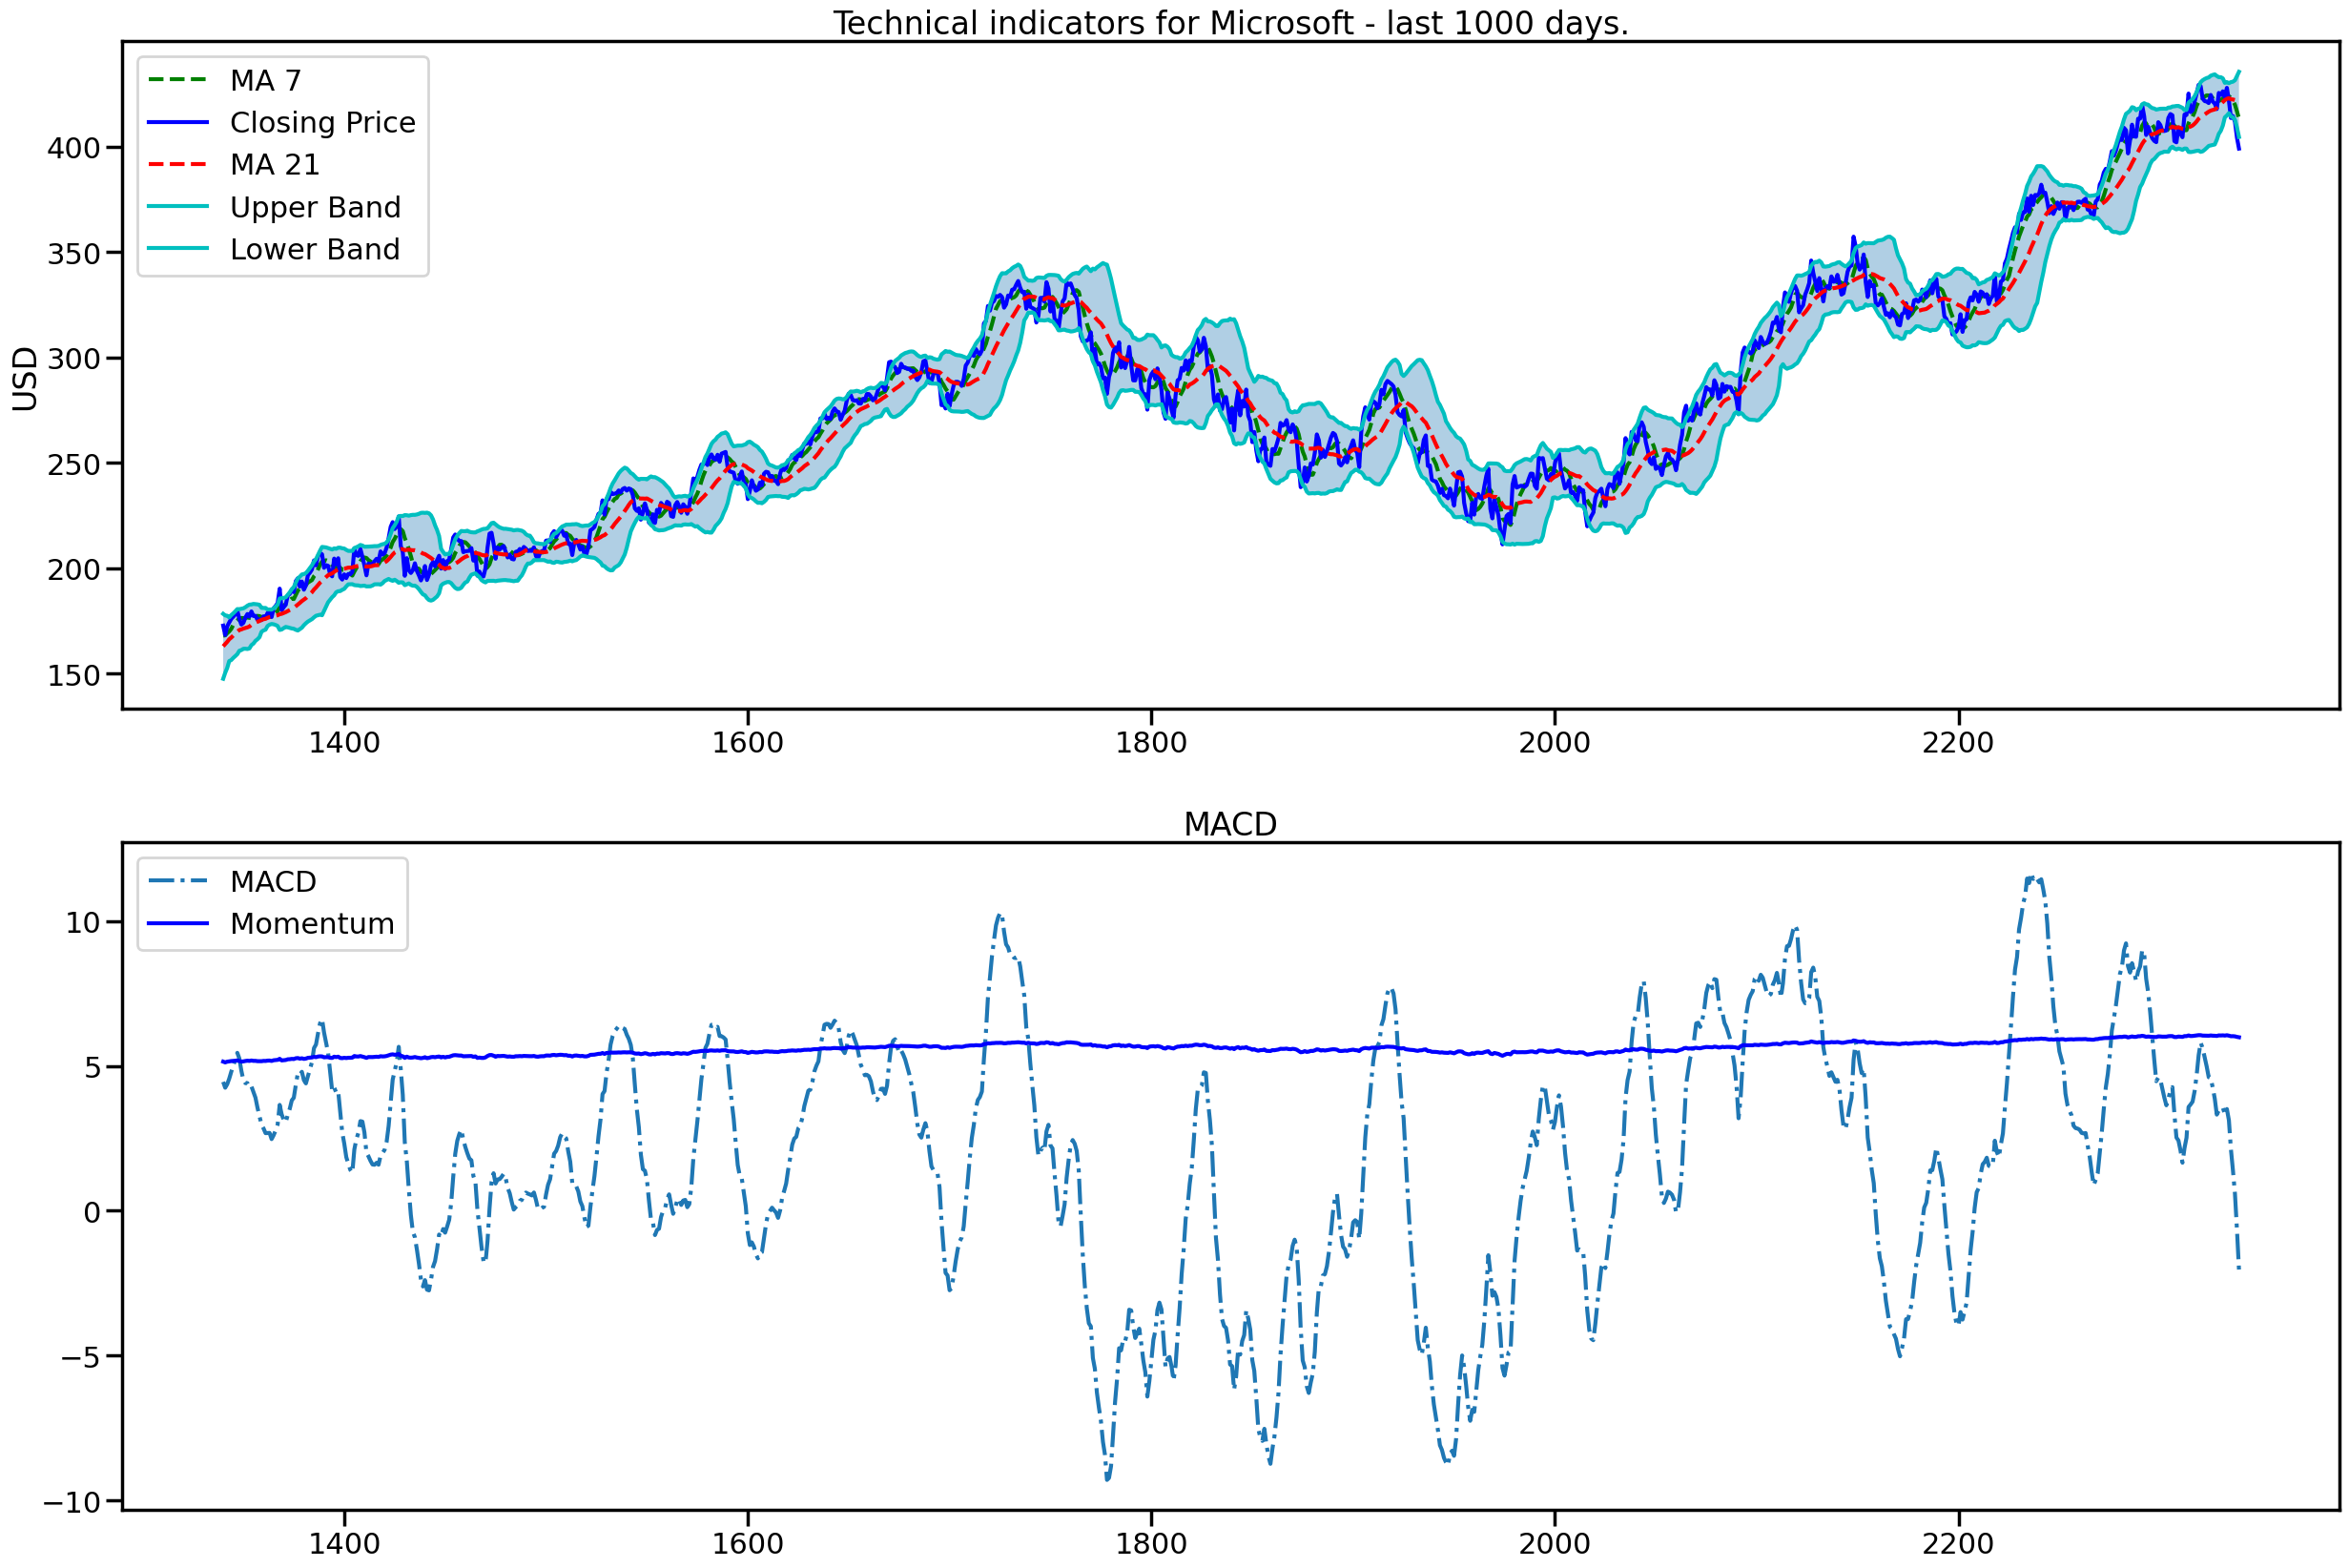

In [32]:
plot_technical_indicators(microsoft_df, 'Adj Close', 1000, 'Microsoft')

Text(0.5, 1.0, 'Params')

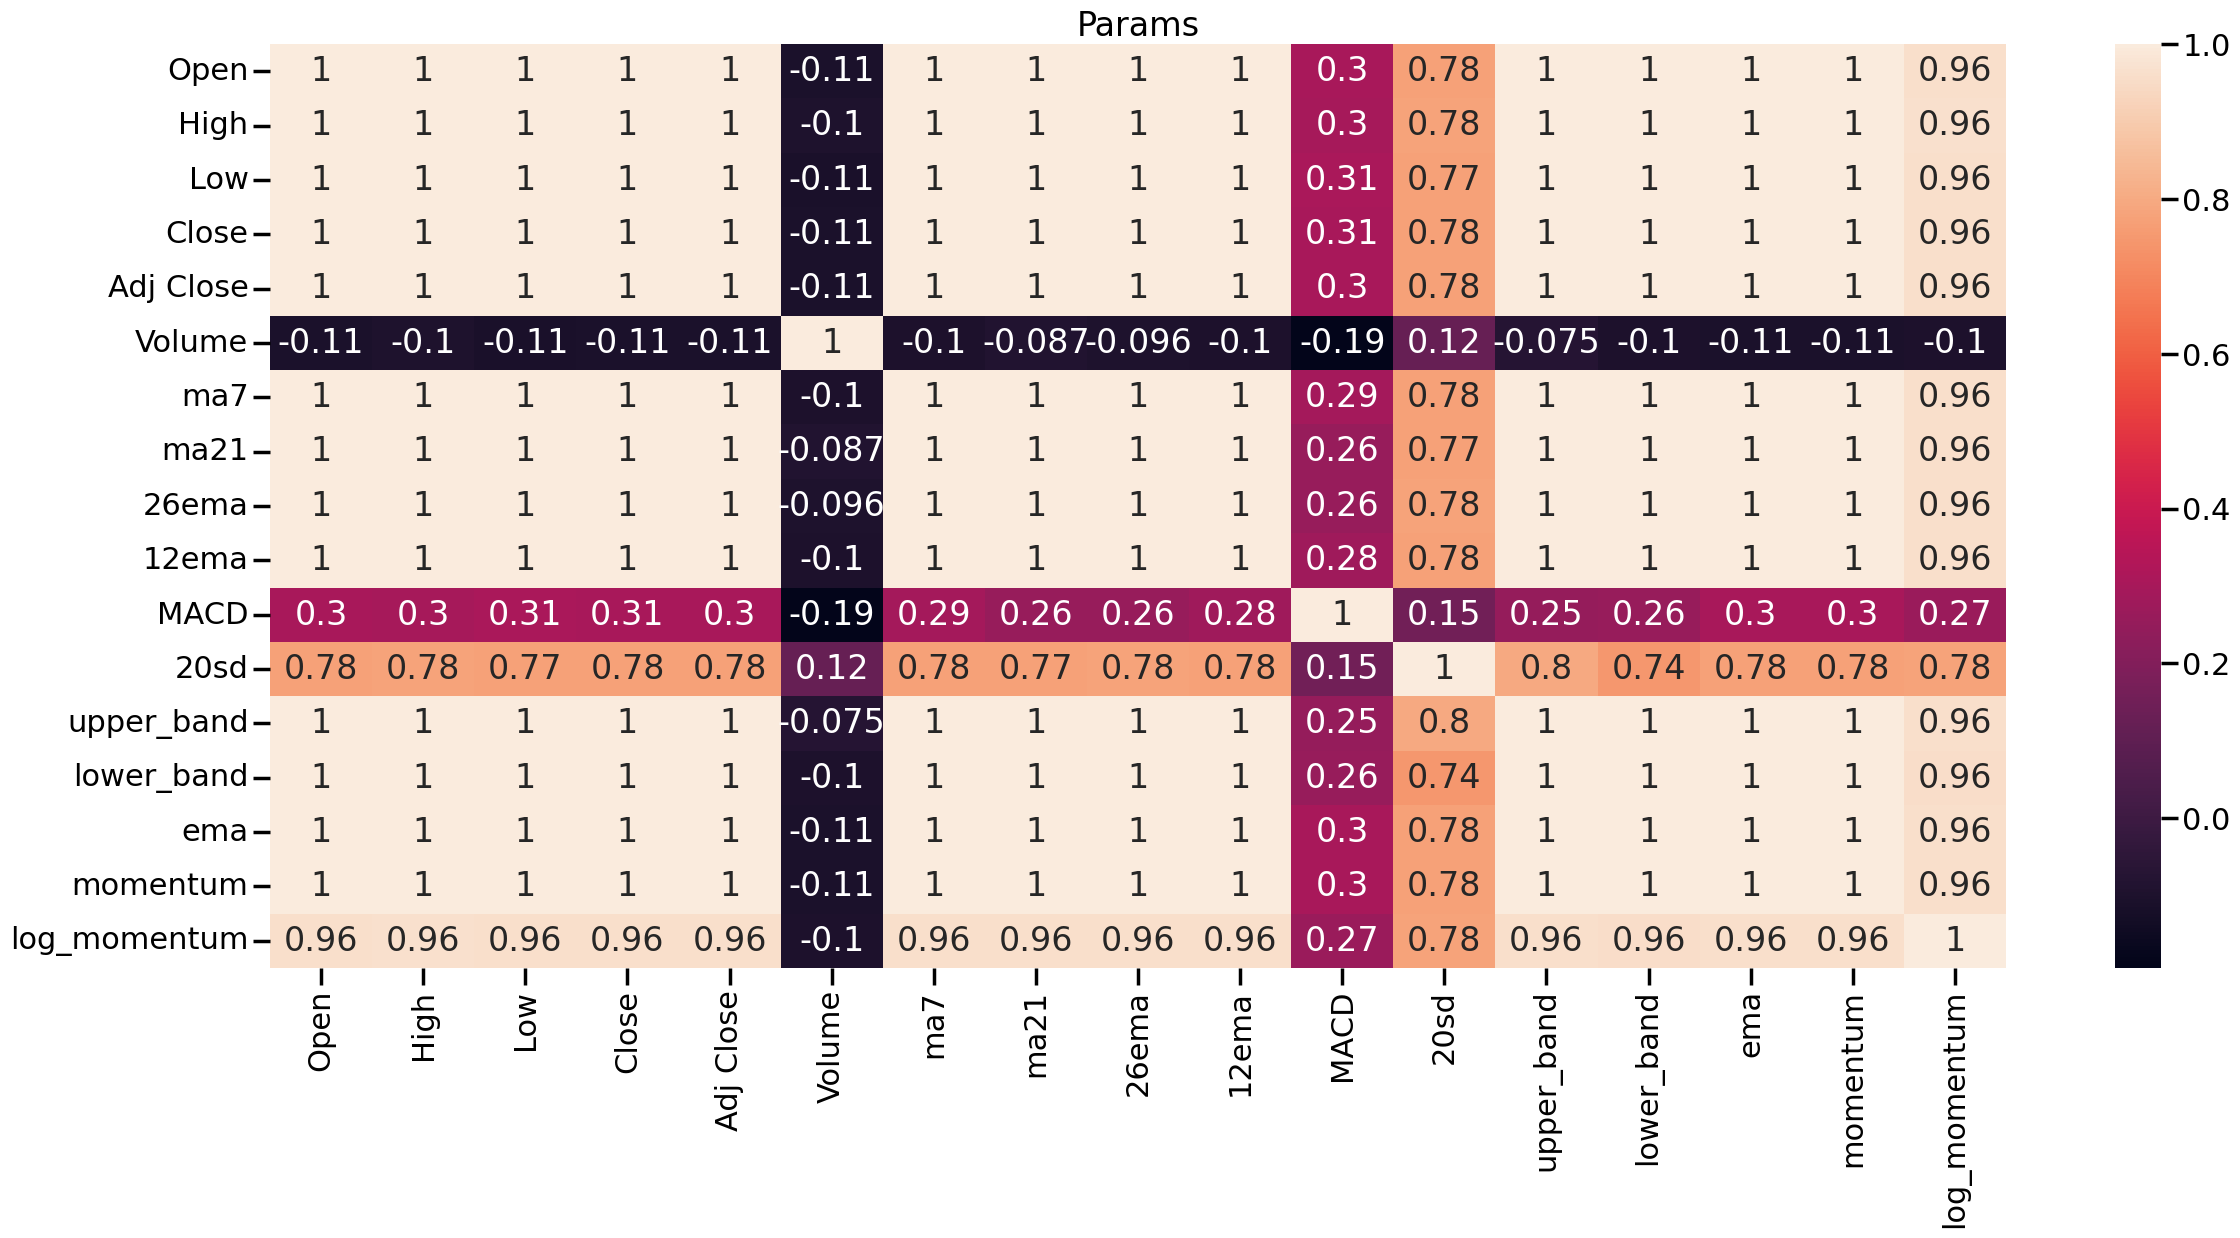

In [33]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(microsoft_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Analysis of Google, Amazon and Microsoft stocks

In [34]:
company_list = [apple_df, google_df, microsoft_df]
tech_list = ['Apple', 'Google', 'Microsoft']

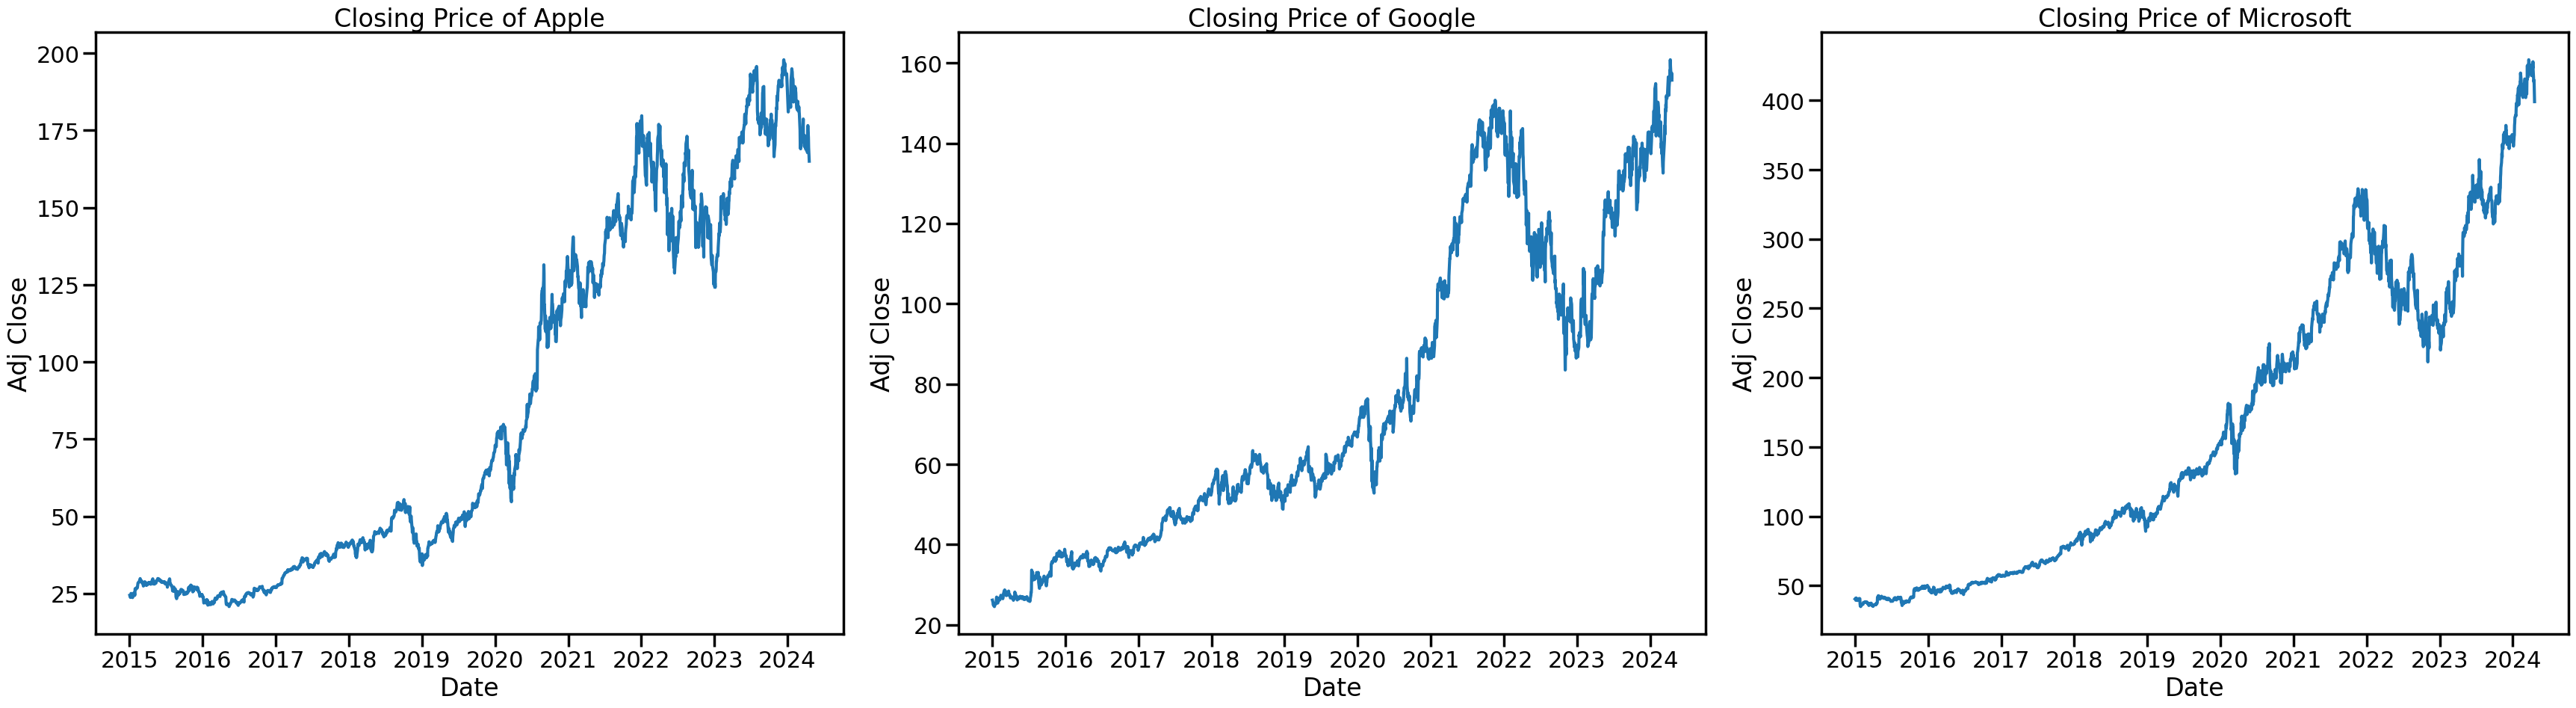

In [35]:
# Let's see a historical view of the closing price
plt.figure(figsize=(35, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(1, 3, i)
    plt.plot(company['Date'], company['Adj Close'])
#     company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel('Date')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

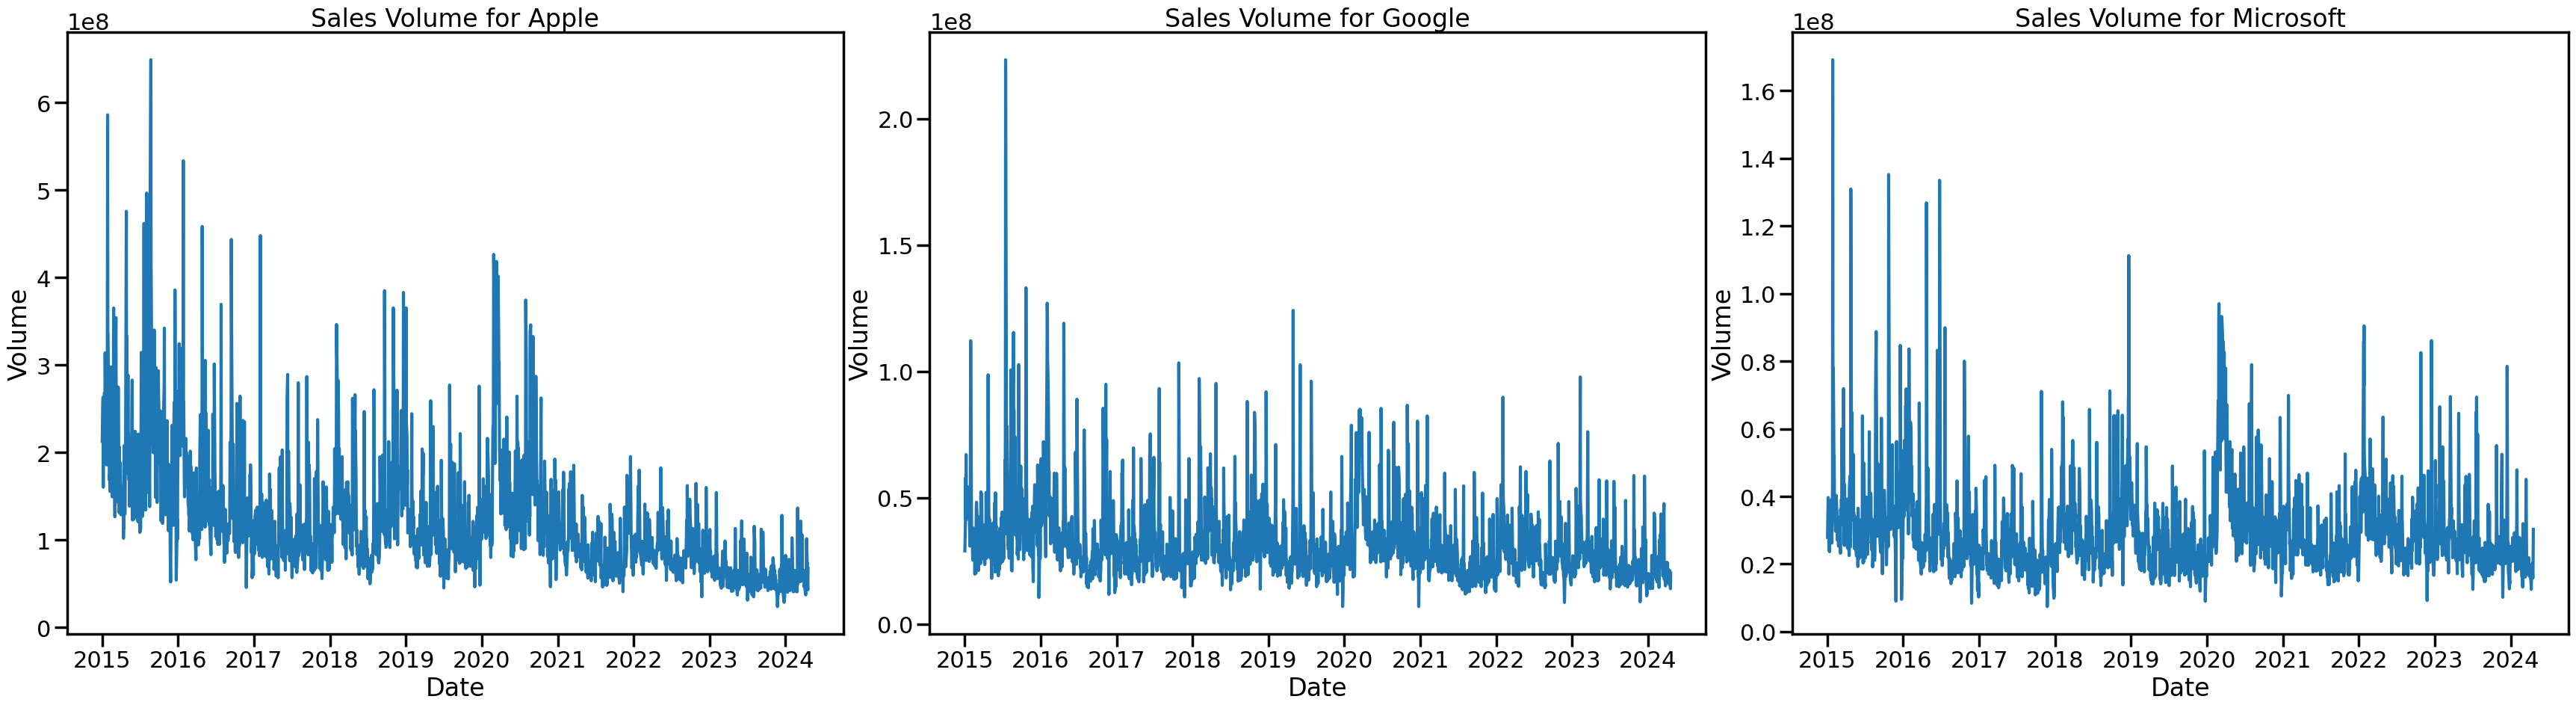

In [36]:
# Now let's plot the total volume of stock being traded each day
# we can see the slight decreasing trend in volume of stocks traded
plt.figure(figsize=(35, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(1, 3, i)
    plt.plot(company['Date'], company['Volume'])
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

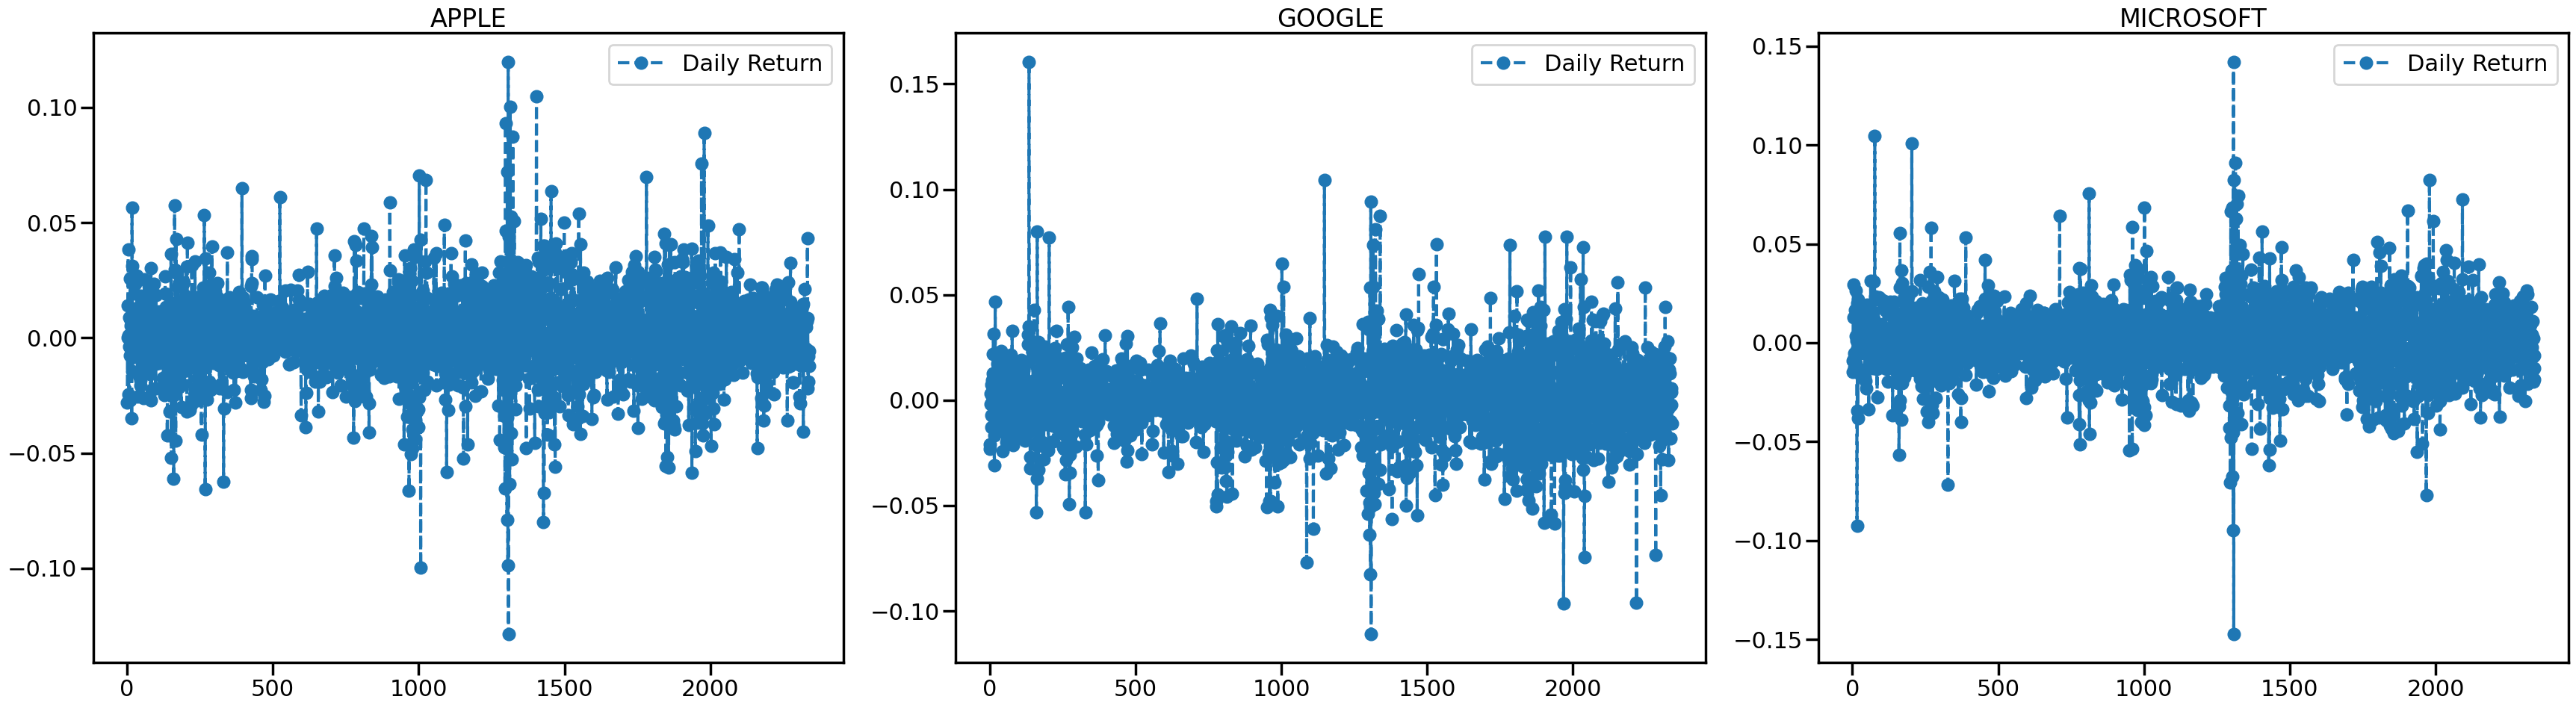

In [37]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(35)

apple_df['Daily Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o')
axes[0].set_title('APPLE')

google_df['Daily Return'].plot(ax=axes[1], legend=True, linestyle='--', marker='o')
axes[1].set_title('GOOGLE')

microsoft_df['Daily Return'].plot(ax=axes[2], legend=True, linestyle='--', marker='o')
axes[2].set_title('MICROSOFT')

fig.tight_layout()

### LSTM models for each stock

##### Apple stock prediction model

In [38]:
apple_df = apple_df.dropna()

In [39]:
apple_df.head()

Date       Open       High        Low      Close  Adj Close  \
20 2015-02-02  29.512501  29.792500  29.020000  29.657499  26.513823   
21 2015-02-03  29.625000  29.772499  29.402500  29.662500  26.518286   
22 2015-02-04  29.625000  30.127501  29.577499  29.889999  26.721676   
23 2015-02-05  30.004999  30.057501  29.812500  29.985001  26.912407   
24 2015-02-06  30.004999  30.062500  29.612499  29.732500  26.685772   

       Volume stock_type        ma7       ma21      26ema      12ema  \
20  250956400       AAPL  25.709539  24.813410  25.124878  25.474017   
21  207662800       AAPL  25.890574  24.912601  25.251358  25.638852   
22  280598800       AAPL  26.096832  25.054258  25.382628  25.809091   
23  168984800       AAPL  26.456775  25.204890  25.517160  25.981969   
24  174826400       AAPL  26.587342  25.328873  25.618525  26.091935   

        MACD      20sd  upper_band  lower_band        ema   momentum  \
20  0.349140  0.874321   26.562052   23.064767  26.404206  25.513823   
21  0.387494  0.944609   26.801820   23.023383  26.480259  25.518286   
22  0.426463  0.983316   27.020889   23.087626  26.641204  25.721676   
23  0.464809  1.015161   27.235213   23.174568  26.822006  25.912407   
24  0.473409  1.030065   27.389003   23.268743  26.731183  25.685772   

    log_momentum  Daily Return  
20      3.239220      0.012547  
21      3.239395      0.000168  
22      3.247334      0.007670  
23      3.254722      0.007138  
24      3.245937     -0.008421

In [40]:
apple_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'stock_type', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return'],
      dtype='object')

In [41]:
apple_data_training = apple_df[apple_df['Date'] <= '2022-12-31'].copy()
apple_data_testing = apple_df[apple_df['Date'] > '2022-12-31'].copy()

In [42]:
apple_data_training = apple_data_training[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]
apple_data_testing = apple_data_testing[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]

In [43]:
apple_scalar = MinMaxScaler()

apple_data_training_scaled = apple_scalar.fit_transform(apple_data_training)
print(apple_data_training_scaled.shape)
apple_data_training_scaled

(1994, 17)


array([[0.03612193, 0.04379255, 0.04296271, ..., 0.03612193, 0.11580171,
        0.56828792],
       [0.03615001, 0.0444951 , 0.04283772, ..., 0.03615001, 0.11588116,
        0.5184651 ],
       [0.03742957, 0.0444951 , 0.04505617, ..., 0.03742957, 0.11948712,
        0.54865757],
       ...,
       [0.65684777, 0.66926869, 0.6756081 , ..., 0.65684777, 0.83461073,
        0.39428358],
       [0.67915401, 0.65877721, 0.67217106, ..., 0.67915401, 0.84739815,
        0.63178941],
       [0.68115332, 0.66140012, 0.66885904, ..., 0.68115332, 0.8485269 ,
        0.52772411]])

In [44]:
apple_X_train = []
apple_y_train = []

In [45]:
for i in range(60, apple_data_training.shape[0]):
    apple_X_train.append(apple_data_training_scaled[i-60: i, 1:])
    apple_y_train.append(apple_data_training_scaled[i, 0])

In [46]:
apple_X_train, apple_y_train = np.array(apple_X_train), np.array(apple_y_train)
apple_X_train.shape, apple_y_train.shape

((1934, 60, 16), (1934,))

In [47]:
def create_model(X_train):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 16)))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.4))

    regressor.add(LSTM(units = 120, activation = 'relu'))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units = 1))
    return regressor

In [48]:
# Compiling the RNN
apple_regressor = create_model(apple_X_train)
apple_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [49]:
apple_regressor.fit(apple_X_train, apple_y_train, epochs=50, batch_size = 64)

Epoch 1/50
31/31 [==============================] - 13s 207ms/step - loss: 0.0444
Epoch 2/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0096
Epoch 3/50
31/31 [==============================] - 7s 215ms/step - loss: 0.0077
Epoch 4/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0065
Epoch 5/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0058
Epoch 6/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0061
Epoch 7/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0051
Epoch 8/50
31/31 [==============================] - 7s 215ms/step - loss: 0.0054
Epoch 9/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0049
Epoch 10/50
31/31 [==============================] - 6s 209ms/step - loss: 0.0051
Epoch 11/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0050
Epoch 12/50
31/31 [==============================] - 6s 202ms/step - loss: 0.0045
Epoch 13/50
31/31 [=====

In [50]:
apple_past_60 = apple_data_training.tail(60)

apple_dt = pd.concat([apple_past_60, apple_data_testing], axis=0)

In [51]:
apple_inputs = apple_scalar.fit_transform(apple_dt)
print(apple_inputs.shape)
apple_inputs

(386, 17)


array([[0.27183108, 0.27496174, 0.27515654, ..., 0.27183108, 0.32134216,
        0.30215988],
       [0.1999802 , 0.22955132, 0.21336131, ..., 0.1999802 , 0.24099974,
        0.08249524],
       [0.2044203 , 0.20011103, 0.19652057, ..., 0.2044203 , 0.24605329,
        0.36771936],
       ...,
       [0.59482736, 0.60547142, 0.59679886, ..., 0.59482736, 0.64923921,
        0.29105252],
       [0.58179987, 0.58353   , 0.56882399, ..., 0.58179987, 0.6369453 ,
        0.30881281],
       [0.55411675, 0.55825584, 0.53764785, ..., 0.55411675, 0.61058329,
        0.26137825]])

In [52]:
apple_X_test = []
apple_y_test = []

for i in range(60, apple_inputs.shape[0]):
    apple_X_test.append(apple_inputs[i-60:i, 1:])
    apple_y_test.append(apple_inputs[i, 0])
    
apple_X_test, apple_y_test = np.array(apple_X_test), np.array(apple_y_test)
apple_X_test.shape, apple_y_test.shape

((326, 60, 16), (326,))

In [53]:
y_pred = apple_regressor.predict(apple_X_test)

11/11 [==============================] - 1s 43ms/step


In [54]:
scale = 1/apple_scalar.scale_[0]

In [55]:
y_pred = y_pred*scale
apple_y_test = apple_y_test*scale

In [56]:
from sklearn.metrics import r2_score
r2_score(apple_y_test, y_pred)

0.5075298749601268

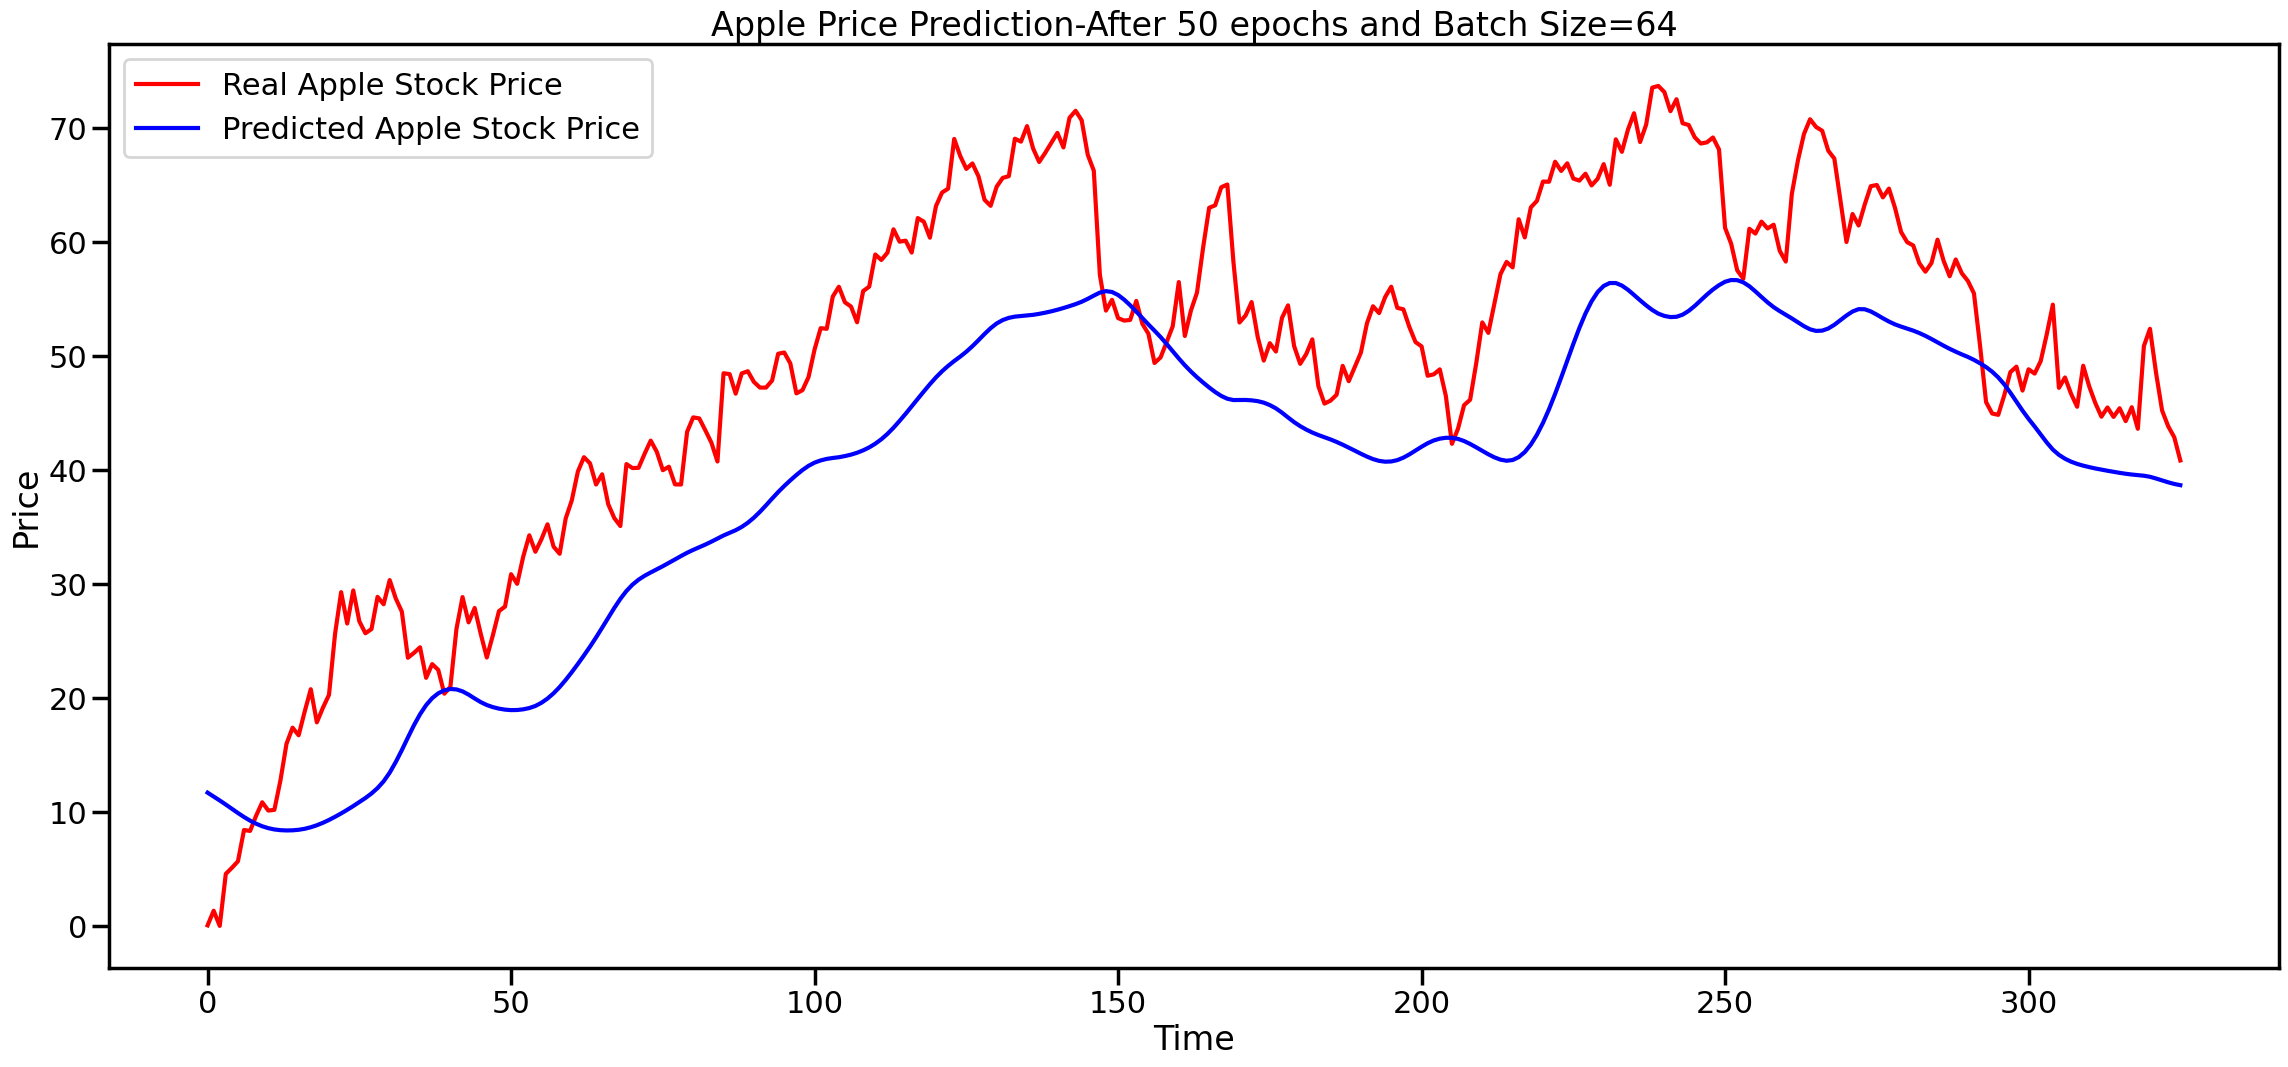

In [57]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(apple_y_test, color = 'red', label = 'Real Apple Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

##### Google Stock price prediction

In [58]:
google_df = google_df.dropna()

In [59]:
google_data_training = google_df[google_df['Date'] <= '2022-12-31'].copy()
google_data_testing = google_df[google_df['Date'] > '2022-12-31'].copy()

In [60]:
google_data_training = google_data_training[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]
google_data_testing = google_data_testing[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]

In [61]:
google_scalar = MinMaxScaler()

google_data_training_scaled = google_scalar.fit_transform(google_data_training)
print(google_data_training_scaled.shape)
google_data_training_scaled

(1994, 17)


array([[0.00408555, 0.00427923, 0.00349572, ..., 0.00408555, 0.01131752,
        0.36720607],
       [0.00438904, 0.00280182, 0.00365406, ..., 0.00438904, 0.01214911,
        0.41411716],
       [0.00180139, 0.00329297, 0.00336589, ..., 0.00180139, 0.00501848,
        0.36372902],
       ...,
       [0.48546259, 0.48872615, 0.49524976, ..., 0.48546259, 0.68786777,
        0.34725253],
       [0.50540371, 0.48499268, 0.50195807, ..., 0.50540371, 0.70385728,
        0.51488363],
       [0.50364189, 0.48765376, 0.49771083, ..., 0.50364189, 0.70246294,
        0.39971268]])

In [62]:
google_X_train = []
google_y_train = []

In [63]:
for i in range(60, google_data_training.shape[0]):
    google_X_train.append(google_data_training_scaled[i-60: i, 1:])
    google_y_train.append(google_data_training_scaled[i, 0])

In [64]:
google_X_train, google_y_train = np.array(google_X_train), np.array(google_y_train)
google_X_train.shape, google_y_train.shape

((1934, 60, 16), (1934,))

In [65]:
# Compiling the RNN
google_regressor = create_model(google_X_train)
google_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [66]:
google_regressor.fit(google_X_train, google_y_train, epochs=50, batch_size = 64)

Epoch 1/50
31/31 [==============================] - 12s 213ms/step - loss: 0.0813
Epoch 2/50
31/31 [==============================] - 6s 207ms/step - loss: 0.0128
Epoch 3/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0083
Epoch 4/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0083
Epoch 5/50
31/31 [==============================] - 7s 211ms/step - loss: 0.0070
Epoch 6/50
31/31 [==============================] - 7s 215ms/step - loss: 0.0063
Epoch 7/50
31/31 [==============================] - 7s 209ms/step - loss: 0.0059
Epoch 8/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0059
Epoch 9/50
31/31 [==============================] - 6s 208ms/step - loss: 0.0053
Epoch 10/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0052
Epoch 11/50
31/31 [==============================] - 7s 214ms/step - loss: 0.0046
Epoch 12/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0048
Epoch 13/50
31/31 [=====

In [67]:
google_past_60 = google_data_training.tail(60)

google_dt = pd.concat([google_past_60, google_data_testing], axis=0)

In [68]:
google_inputs = google_scalar.fit_transform(google_dt)
print(google_inputs.shape)
google_inputs

(386, 17)


array([[0.24256146, 0.21385581, 0.22860947, ..., 0.24256146, 0.30977317,
        0.5554666 ],
       [0.20802073, 0.20248763, 0.19787088, ..., 0.20802073, 0.26935025,
        0.40409068],
       [0.19689524, 0.19178811, 0.17884226, ..., 0.19689524, 0.25609666,
        0.50464803],
       ...,
       [0.949418  , 0.95867331, 0.95982705, ..., 0.949418  , 0.96253097,
        0.58679643],
       [0.95692126, 0.95512912, 0.95721894, ..., 0.95692126, 0.96814805,
        0.57561207],
       [0.93441148, 0.96616291, 0.95063218, ..., 0.93441148, 0.95123384,
        0.49076324]])

In [69]:
google_X_test = []
google_y_test = []

for i in range(60, google_inputs.shape[0]):
    google_X_test.append(google_inputs[i-60:i, 1:])
    google_y_test.append(google_inputs[i, 0])
    
google_X_test, google_y_test = np.array(google_X_test), np.array(google_y_test)
google_X_test.shape, google_y_test.shape

((326, 60, 16), (326,))

In [70]:
y_pred = google_regressor.predict(google_X_test)

11/11 [==============================] - 1s 44ms/step


In [71]:
scale = 1/google_scalar.scale_[0]

In [72]:
y_pred = y_pred*scale
google_y_test = google_y_test*scale

In [73]:
from sklearn.metrics import r2_score
r2_score(google_y_test, y_pred)

0.6722868222850746

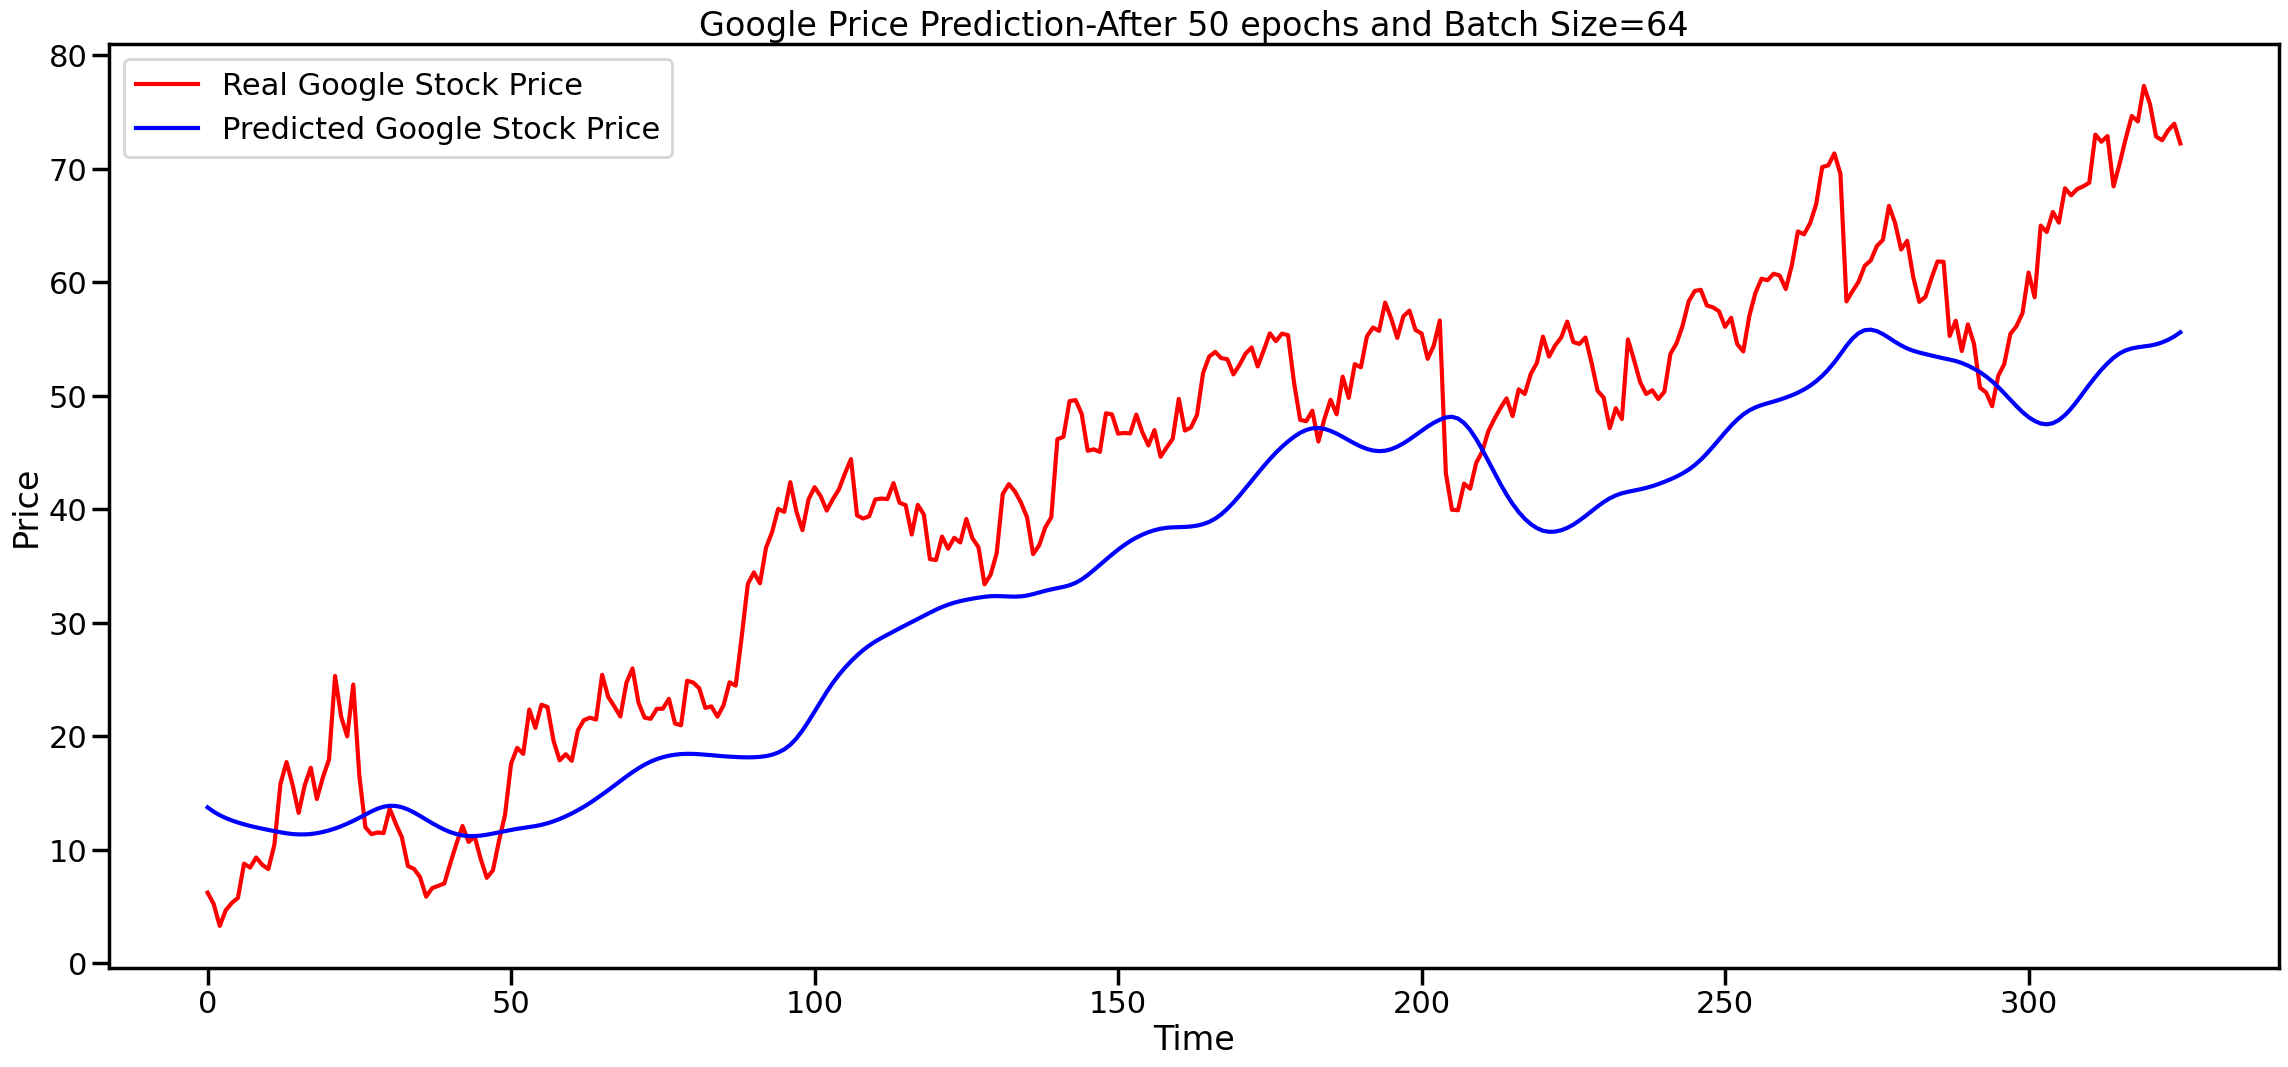

In [74]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(google_y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()